# Packages

In [ ]:
# Install Packages
%pip install numpy seaborn pandas scikit-learn matplotlib

In [ ]:
# Import Packages
from sklearn.datasets import load_wine, load_digits
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve, auc
)
# from google.colab import drive

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# Mount Drive

In [ ]:
## Store the images directly in drive
## Alternativly comment out these line and store them locally

## Comment this out if not required
# drive.mount('/content/drive')

## Comment out one of the below two lines
# folder_path = '/content/drive/My Drive/ML Lab/Ass 2/assets'
folder_path = 'assets'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Utility Functions

In [11]:
def evaluate_model(y_true, y_pred, model_name, split_ratio, results_df, title):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    results_df.loc[len(results_df)] = [
        model_name, split_ratio, acc, prec, rec, f1
    ]

    print("\nEvaluation Results:")
    print(results_df.tail(1))

    return results_df

In [12]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(os.path.join(folder_path, f'Confusion_Matrix - {title}'))
    plt.show()
    plt.close()

In [13]:
def plot_roc_curve(model, X_test, y_test, title, n_classes):
    y_score = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

    plt.figure(figsize=(6,5))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.savefig(os.path.join(folder_path, f'ROC Curve - {title}'))
    plt.show()
    plt.close()

# Model Training

In [54]:
def train_and_evaluate(X, y, dataset_name):
    results = pd.DataFrame(columns=['Model', 'Split', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    splits = [0.5, 0.4, 0.3, 0.2]

    classifiers = {
        'SVM-linear': SVC(kernel='linear', probability=True),
        'SVM-poly': SVC(kernel='poly', probability=True),
        'SVM-rbf': SVC(kernel='rbf', probability=True),
        'SVM-sigmoid': SVC(kernel='sigmoid', probability=True),
        'MLP': MLPClassifier(max_iter=500, random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42)
    }

    param_grids = {
        'SVM-linear': {
            'C': [0.1, 1, 10]
        },
        'SVM-poly': {
            'C': [0.1, 1, 10],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto']
        },
        'SVM-rbf': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.01, 0.1]
        },
        'SVM-sigmoid': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto']
        },
        'MLP': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'learning_rate_init': [0.001, 0.01],
            'momentum': [0.8, 0.9],
            'max_iter': [300, 500]
        },
        'RandomForest': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    }

    for split in splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=split, random_state=42, stratify=y
        )
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for name, clf in classifiers.items():
            split_ratio = f'{int((1 - split) * 100)}:{int(split * 100)}'
            title = f'{name}-{dataset_name} ({split_ratio})'
            print(f"{name} train-test split: {split_ratio}")

            # Train default model
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            print(f"[Default] {name} accuracy: {accuracy_score(y_test, y_pred):.4f}")

            # Tune model with GridSearchCV
            grid = GridSearchCV(clf, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            y_pred_tuned = best_model.predict(X_test)

            print(f"[Tuned] {name} accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
            print(f"[Tuned] {name} best params: {grid.best_params_}")

            # Evaluate
            results = evaluate_model(
                y_test, y_pred_tuned, f'{name}-{dataset_name}',
                split_ratio, results, title
            )
            plot_confusion(y_test, y_pred_tuned, title)
            plot_roc_curve(clf, X_test, y_test, title, len(np.unique(y)))

    results.to_csv(os.path.join(folder_path, f'{dataset_name}.csv'), index=False)
    return results

In [42]:
def train_and_evaluate_with_pca(X, y, dataset_name, n_components=0.95):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)

    print(f"[{dataset_name}-PCA] Reduced dimensionality: {X.shape[1]} -> {X_pca.shape[1]}")

    return train_and_evaluate(X_pca, y, f"{dataset_name}-PCA")


# Wine

SVM-linear train-test split: 50:50
[Default] SVM-linear accuracy: 0.9551
[Tuned] SVM-linear accuracy: 0.9775
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
             Model  Split  Accuracy  Precision    Recall  F1-score
0  SVM-linear-Wine  50:50  0.977528    0.97834  0.977528  0.977404


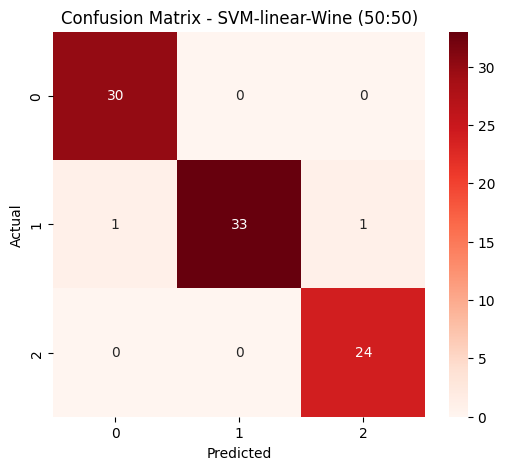

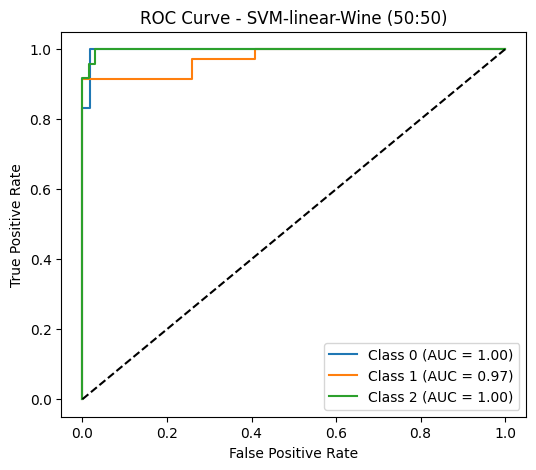

SVM-poly train-test split: 50:50
[Default] SVM-poly accuracy: 0.8539
[Tuned] SVM-poly accuracy: 0.9213
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
           Model  Split  Accuracy  Precision    Recall  F1-score
1  SVM-poly-Wine  50:50  0.921348   0.924041  0.921348  0.920633


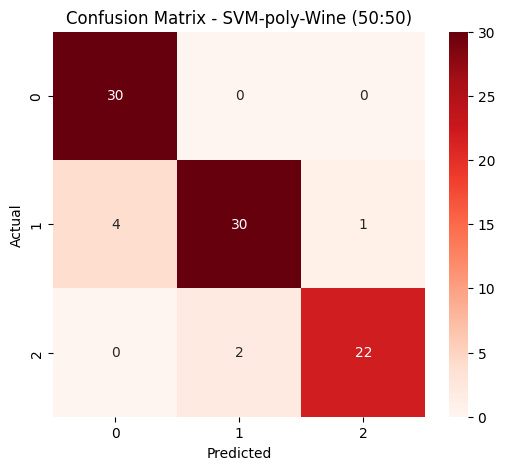

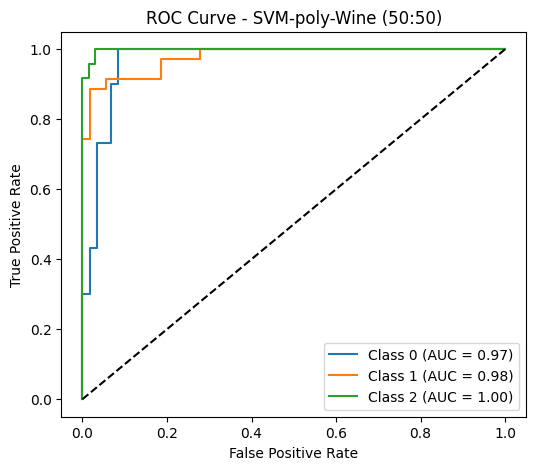

SVM-rbf train-test split: 50:50
[Default] SVM-rbf accuracy: 0.9775
[Tuned] SVM-rbf accuracy: 0.9775
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 0.1}

Evaluation Results:
          Model  Split  Accuracy  Precision    Recall  F1-score
2  SVM-rbf-Wine  50:50  0.977528   0.977528  0.977528  0.977528


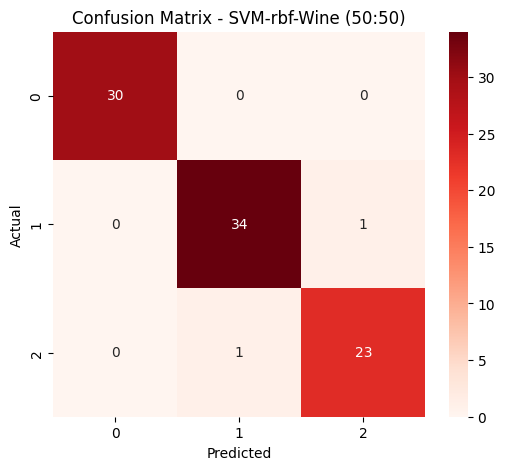

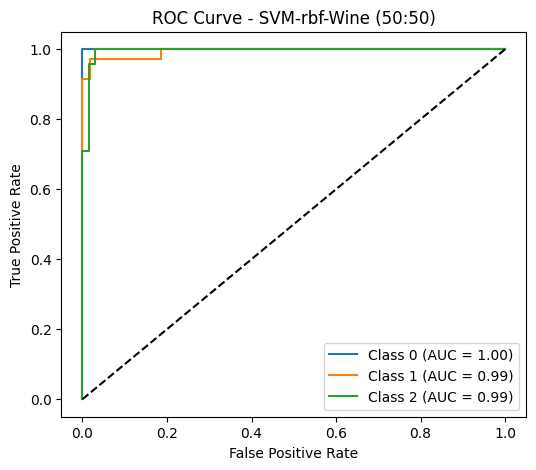

SVM-sigmoid train-test split: 50:50
[Default] SVM-sigmoid accuracy: 0.9551
[Tuned] SVM-sigmoid accuracy: 0.9663
[Tuned] SVM-sigmoid best params: {'C': 0.1, 'gamma': 'scale'}

Evaluation Results:
              Model  Split  Accuracy  Precision    Recall  F1-score
3  SVM-sigmoid-Wine  50:50  0.966292   0.966411  0.966292  0.966163


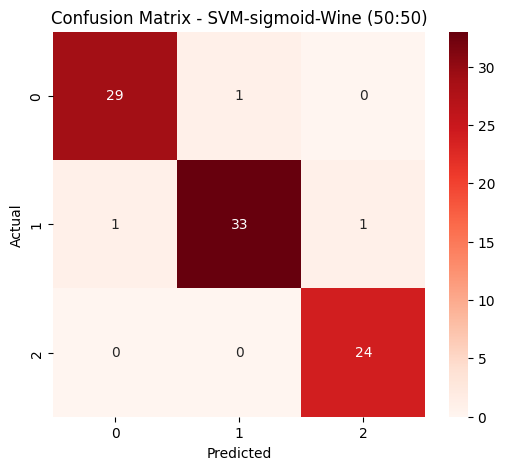

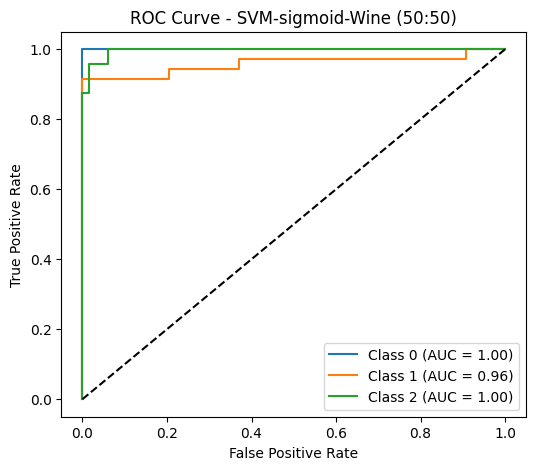

MLP train-test split: 50:50
[Default] MLP accuracy: 0.9551


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[Tuned] MLP accuracy: 0.9775
[Tuned] MLP best params: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'max_iter': 300, 'momentum': 0.8, 'solver': 'sgd'}

Evaluation Results:
      Model  Split  Accuracy  Precision    Recall  F1-score
4  MLP-Wine  50:50  0.977528   0.979257  0.977528  0.977647


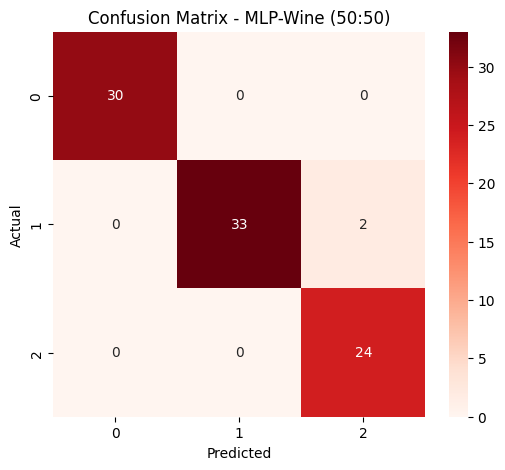

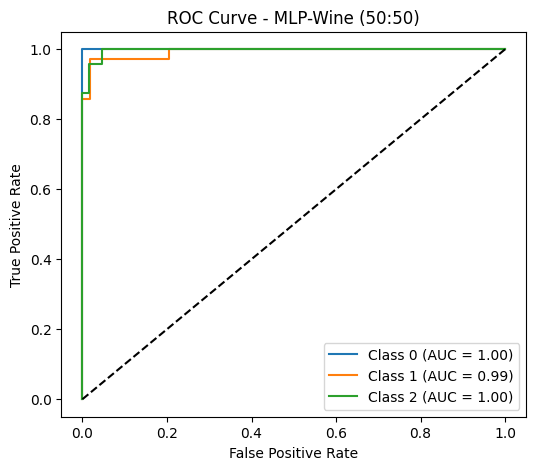

RandomForest train-test split: 50:50
[Default] RandomForest accuracy: 0.9775
[Tuned] RandomForest accuracy: 0.9775
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
               Model  Split  Accuracy  Precision    Recall  F1-score
5  RandomForest-Wine  50:50  0.977528    0.97834  0.977528  0.977404


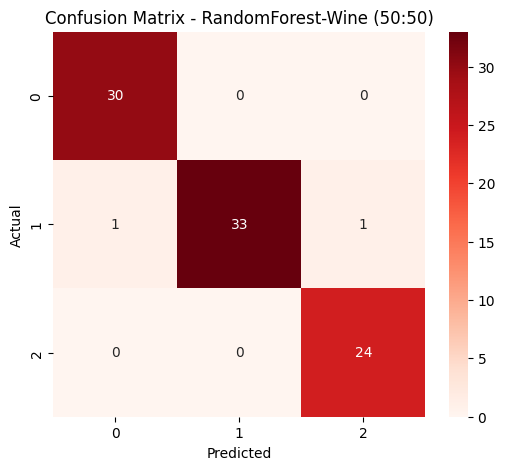

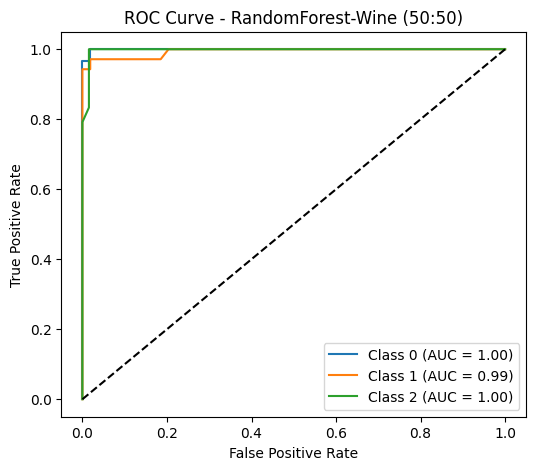

SVM-linear train-test split: 60:40
[Default] SVM-linear accuracy: 0.9583
[Tuned] SVM-linear accuracy: 0.9861
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
             Model  Split  Accuracy  Precision    Recall  F1-score
6  SVM-linear-Wine  60:40  0.986111   0.986667  0.986111  0.986131


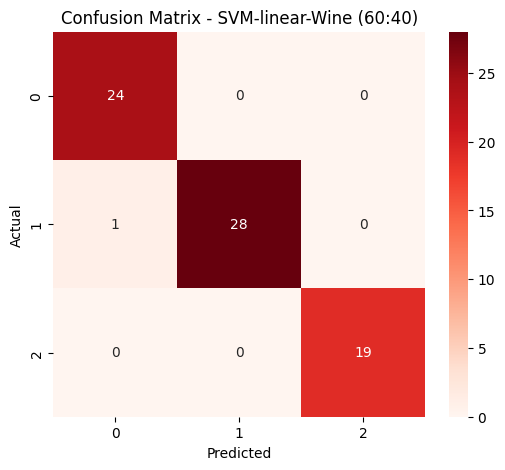

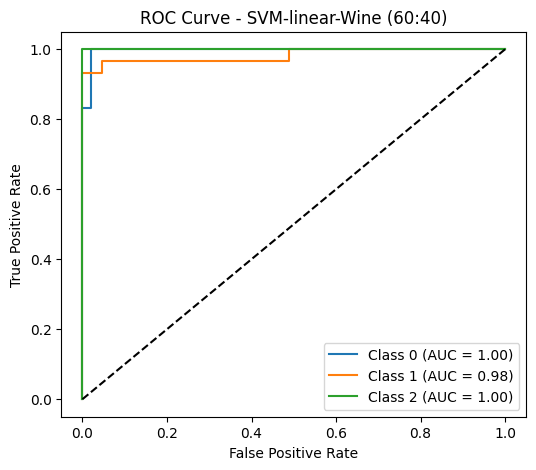

SVM-poly train-test split: 60:40
[Default] SVM-poly accuracy: 0.8889
[Tuned] SVM-poly accuracy: 0.9444
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
           Model  Split  Accuracy  Precision    Recall  F1-score
7  SVM-poly-Wine  60:40  0.944444   0.946581  0.944444  0.944228


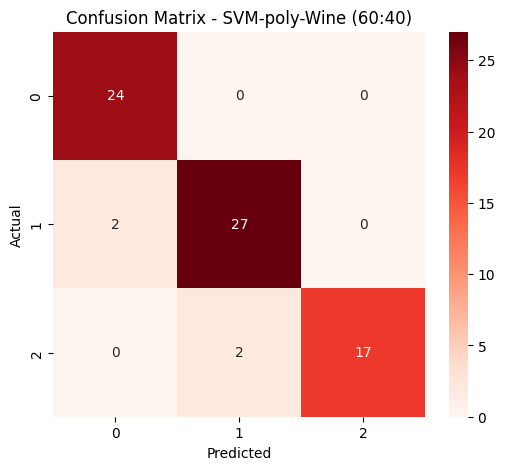

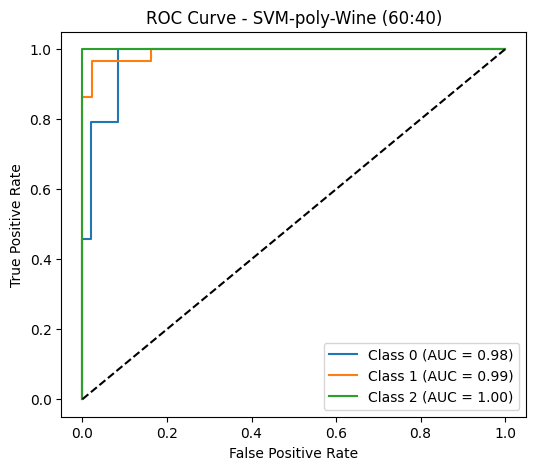

SVM-rbf train-test split: 60:40
[Default] SVM-rbf accuracy: 0.9861
[Tuned] SVM-rbf accuracy: 0.9861
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 0.1}

Evaluation Results:
          Model  Split  Accuracy  Precision    Recall  F1-score
8  SVM-rbf-Wine  60:40  0.986111   0.986574  0.986111  0.986041


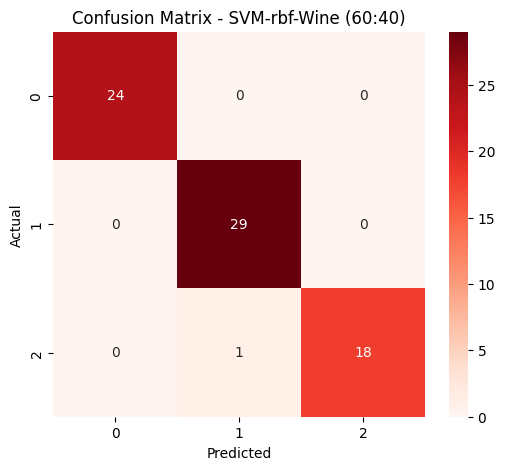

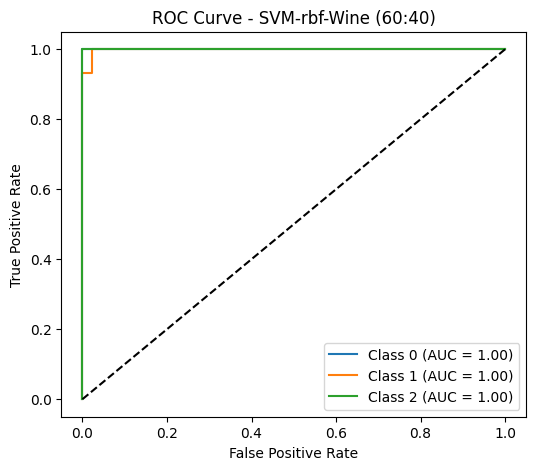

SVM-sigmoid train-test split: 60:40
[Default] SVM-sigmoid accuracy: 1.0000
[Tuned] SVM-sigmoid accuracy: 0.9722
[Tuned] SVM-sigmoid best params: {'C': 0.1, 'gamma': 'scale'}

Evaluation Results:
              Model  Split  Accuracy  Precision    Recall  F1-score
9  SVM-sigmoid-Wine  60:40  0.972222   0.973472  0.972222  0.972046


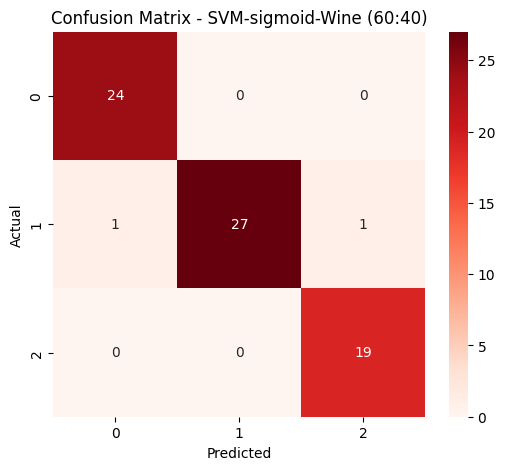

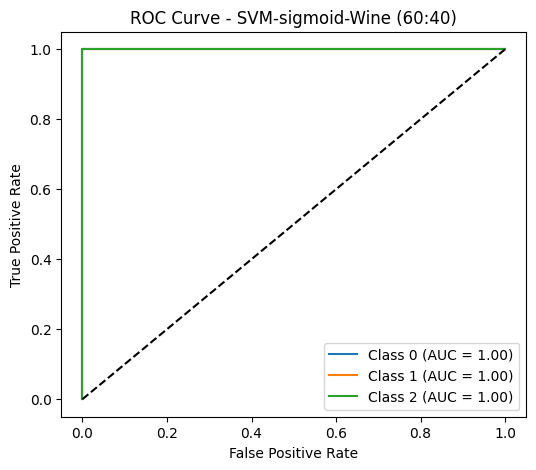

MLP train-test split: 60:40
[Default] MLP accuracy: 0.9722
[Tuned] MLP accuracy: 0.9861
[Tuned] MLP best params: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 500, 'momentum': 0.9, 'solver': 'sgd'}

Evaluation Results:
       Model  Split  Accuracy  Precision    Recall  F1-score
10  MLP-Wine  60:40  0.986111   0.986667  0.986111  0.986131


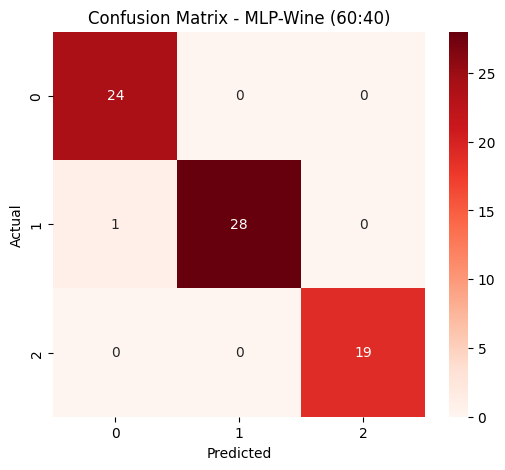

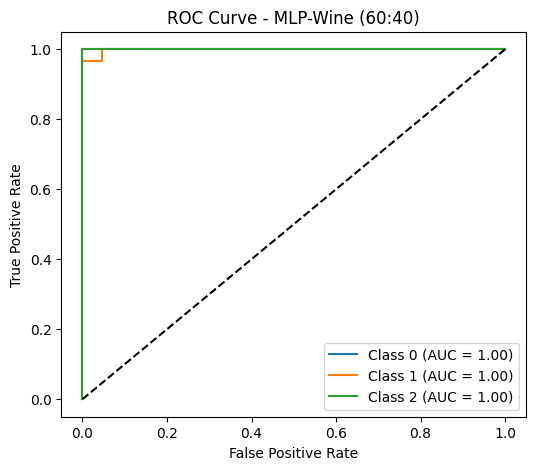

RandomForest train-test split: 60:40
[Default] RandomForest accuracy: 0.9861
[Tuned] RandomForest accuracy: 0.9861
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
                Model  Split  Accuracy  Precision    Recall  F1-score
11  RandomForest-Wine  60:40  0.986111   0.986667  0.986111  0.986131


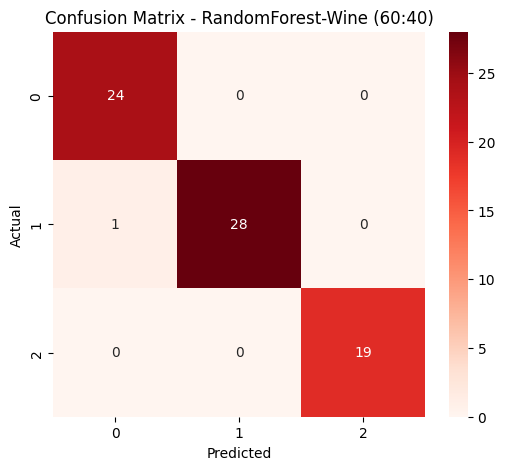

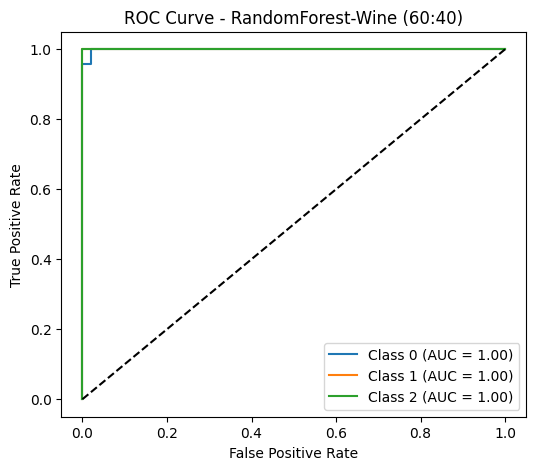

SVM-linear train-test split: 70:30
[Default] SVM-linear accuracy: 0.9630
[Tuned] SVM-linear accuracy: 0.9630
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
              Model  Split  Accuracy  Precision    Recall  F1-score
12  SVM-linear-Wine  70:30  0.962963   0.965095  0.962963  0.962586


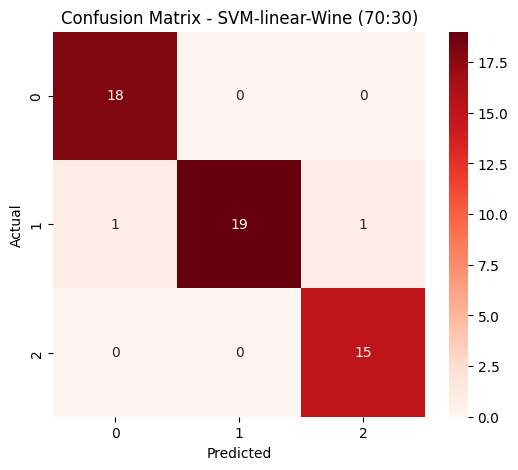

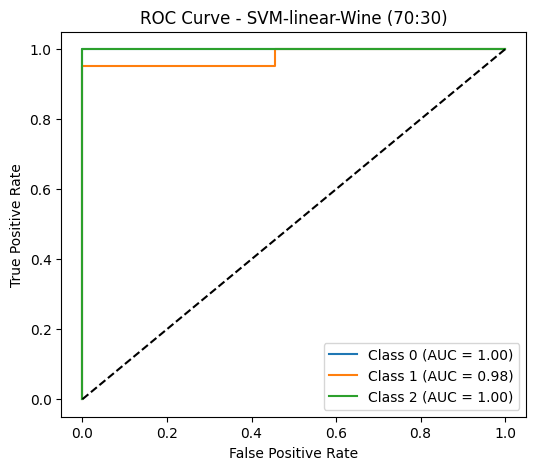

SVM-poly train-test split: 70:30
[Default] SVM-poly accuracy: 0.9074
[Tuned] SVM-poly accuracy: 0.9444
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
            Model  Split  Accuracy  Precision    Recall  F1-score
13  SVM-poly-Wine  70:30  0.944444   0.947103  0.944444  0.944018


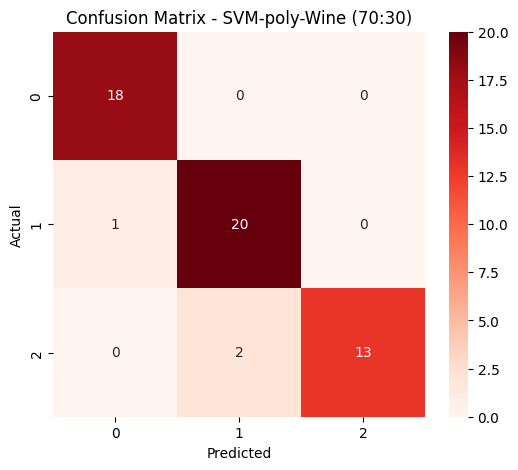

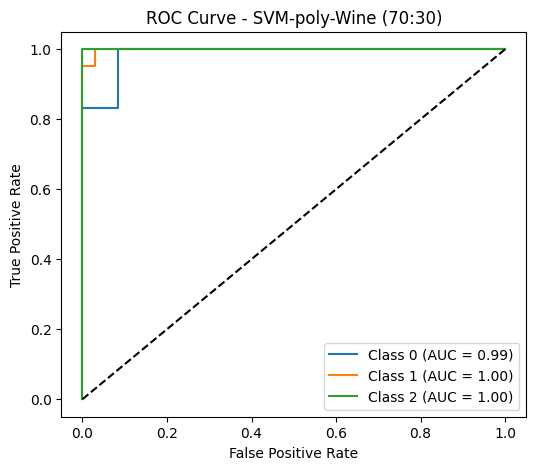

SVM-rbf train-test split: 70:30
[Default] SVM-rbf accuracy: 0.9815
[Tuned] SVM-rbf accuracy: 0.9815
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
           Model  Split  Accuracy  Precision    Recall  F1-score
14  SVM-rbf-Wine  70:30  0.981481   0.982323  0.981481  0.981378


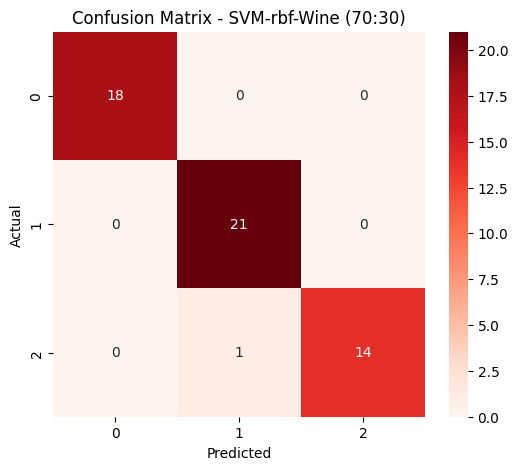

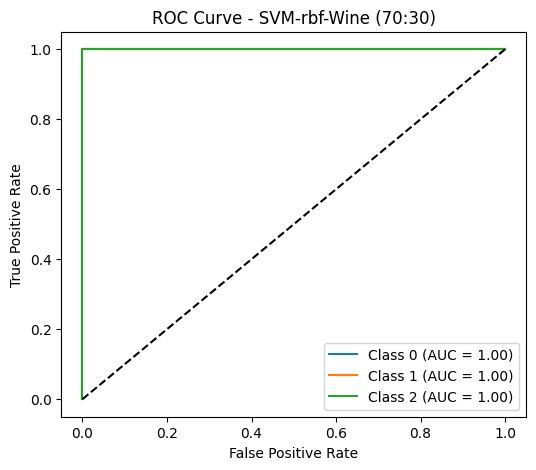

SVM-sigmoid train-test split: 70:30
[Default] SVM-sigmoid accuracy: 0.9630
[Tuned] SVM-sigmoid accuracy: 0.9630
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
               Model  Split  Accuracy  Precision    Recall  F1-score
15  SVM-sigmoid-Wine  70:30  0.962963   0.965095  0.962963  0.962586


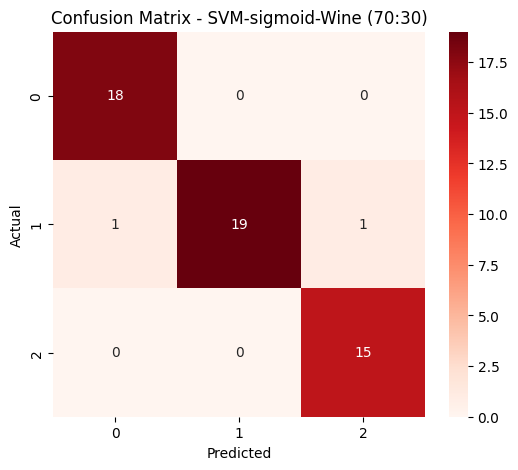

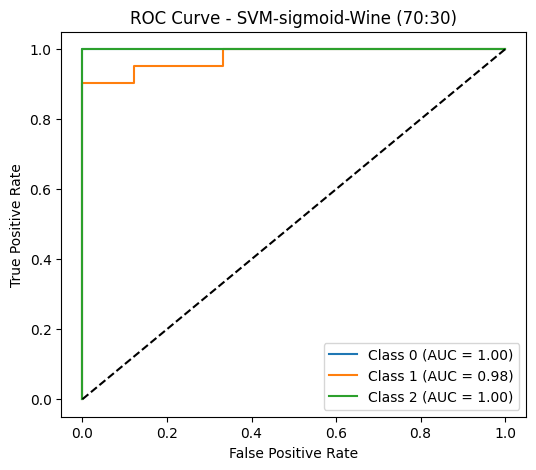

MLP train-test split: 70:30
[Default] MLP accuracy: 1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[Tuned] MLP accuracy: 0.9815
[Tuned] MLP best params: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 500, 'momentum': 0.9, 'solver': 'sgd'}

Evaluation Results:
       Model  Split  Accuracy  Precision    Recall  F1-score
16  MLP-Wine  70:30  0.981481   0.982456  0.981481  0.981506


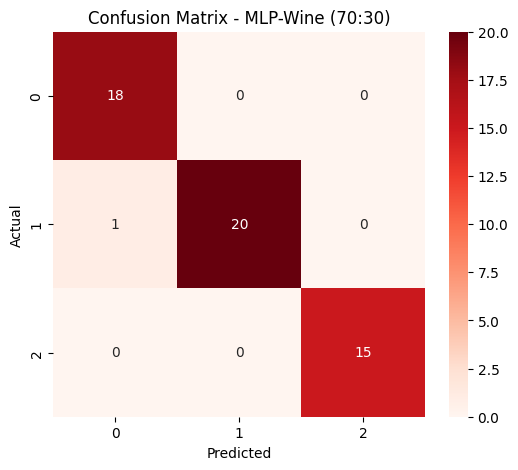

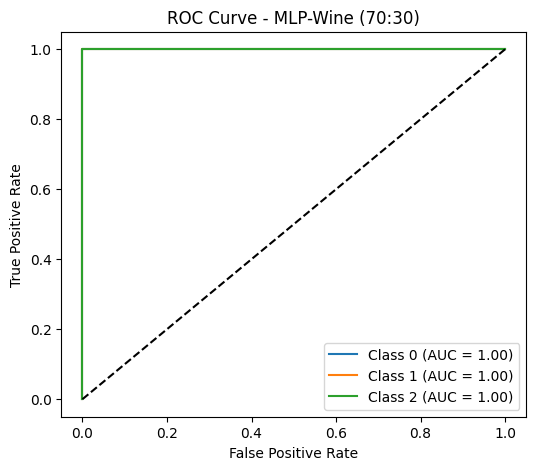

RandomForest train-test split: 70:30
[Default] RandomForest accuracy: 1.0000
[Tuned] RandomForest accuracy: 1.0000
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Evaluation Results:
                Model  Split  Accuracy  Precision  Recall  F1-score
17  RandomForest-Wine  70:30       1.0        1.0     1.0       1.0


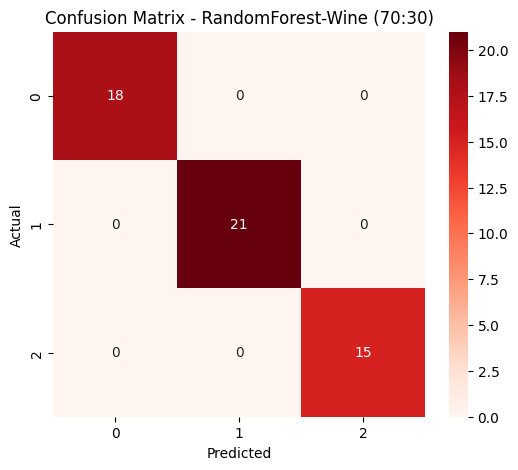

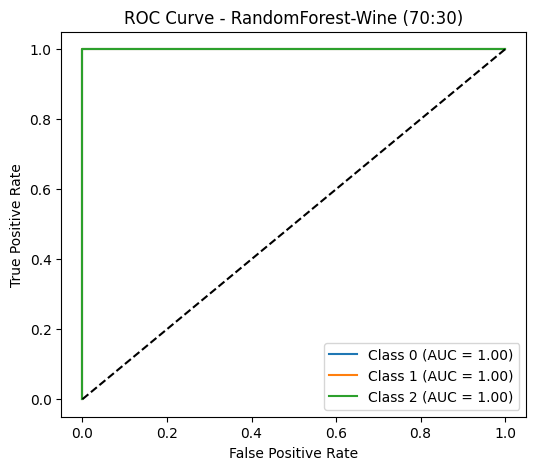

SVM-linear train-test split: 80:20
[Default] SVM-linear accuracy: 0.9444
[Tuned] SVM-linear accuracy: 0.9722
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
              Model  Split  Accuracy  Precision    Recall  F1-score
18  SVM-linear-Wine  80:20  0.972222   0.974074  0.972222   0.97197


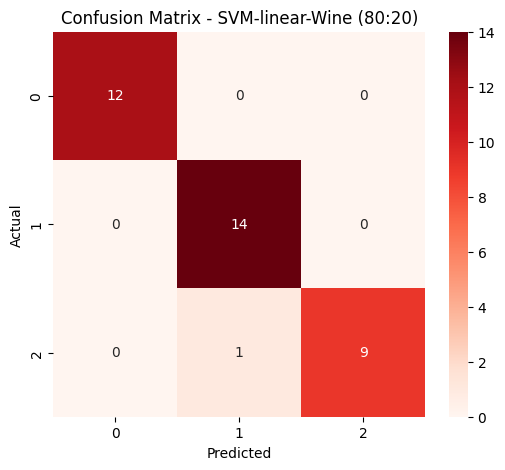

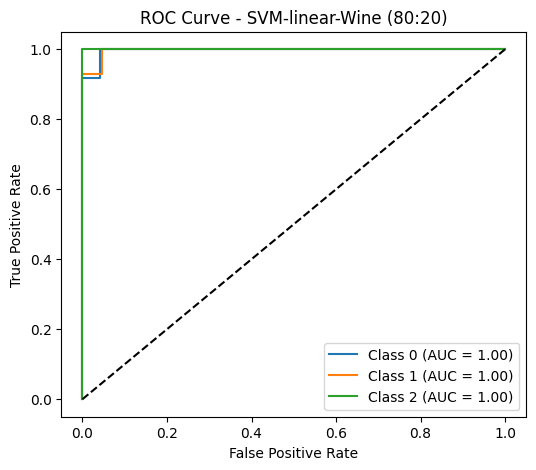

SVM-poly train-test split: 80:20
[Default] SVM-poly accuracy: 0.9444
[Tuned] SVM-poly accuracy: 0.9167
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
            Model  Split  Accuracy  Precision    Recall  F1-score
19  SVM-poly-Wine  80:20  0.916667   0.922507  0.916667  0.915573


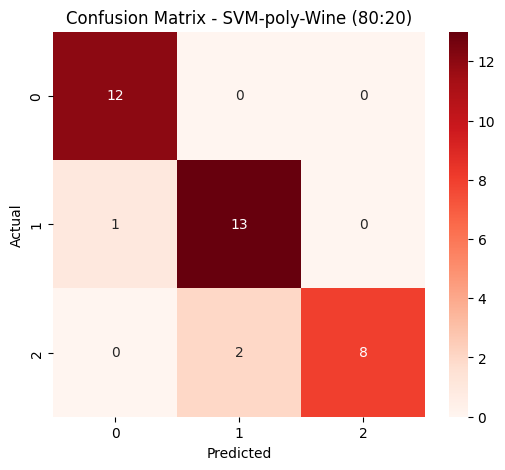

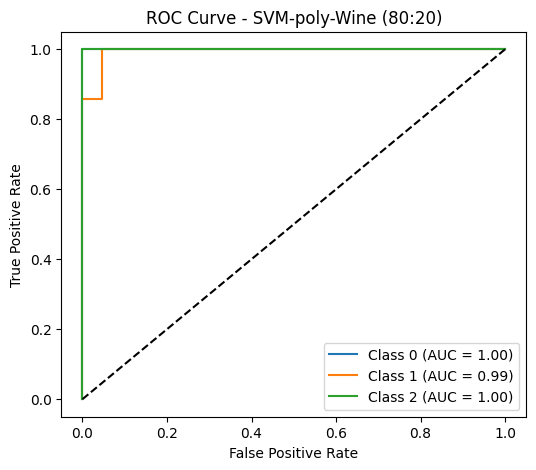

SVM-rbf train-test split: 80:20
[Default] SVM-rbf accuracy: 0.9722
[Tuned] SVM-rbf accuracy: 0.9722
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 0.1}

Evaluation Results:
           Model  Split  Accuracy  Precision    Recall  F1-score
20  SVM-rbf-Wine  80:20  0.972222   0.974074  0.972222   0.97197


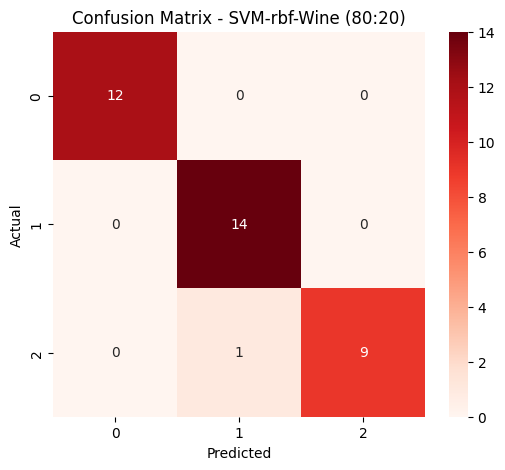

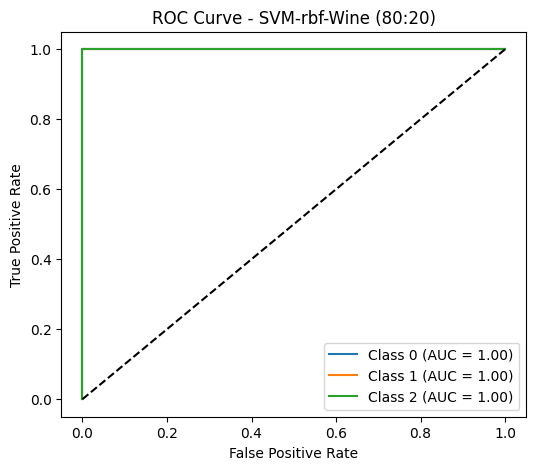

SVM-sigmoid train-test split: 80:20
[Default] SVM-sigmoid accuracy: 1.0000
[Tuned] SVM-sigmoid accuracy: 1.0000
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
               Model  Split  Accuracy  Precision  Recall  F1-score
21  SVM-sigmoid-Wine  80:20       1.0        1.0     1.0       1.0


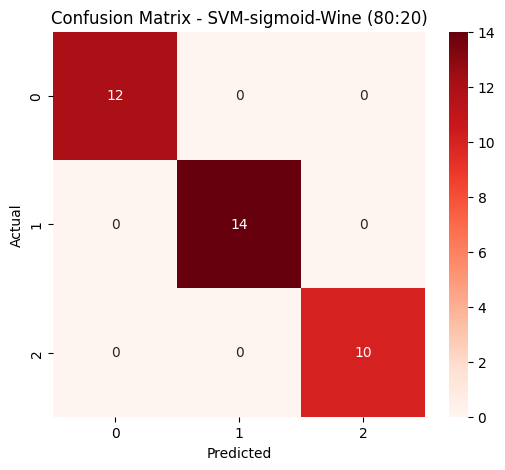

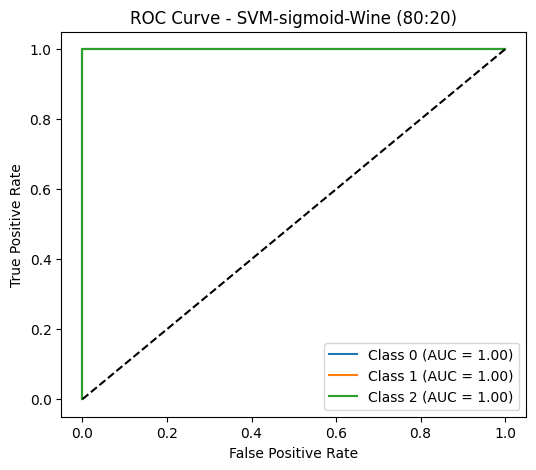

MLP train-test split: 80:20
[Default] MLP accuracy: 0.9722


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[Tuned] MLP accuracy: 0.9444
[Tuned] MLP best params: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 500, 'momentum': 0.9, 'solver': 'sgd'}

Evaluation Results:
       Model  Split  Accuracy  Precision    Recall  F1-score
22  MLP-Wine  80:20  0.944444   0.946581  0.944444  0.944269


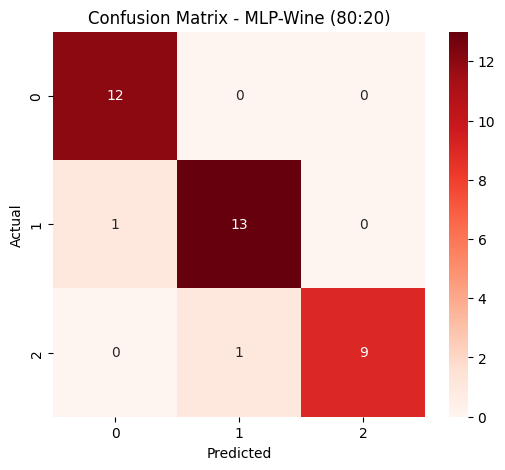

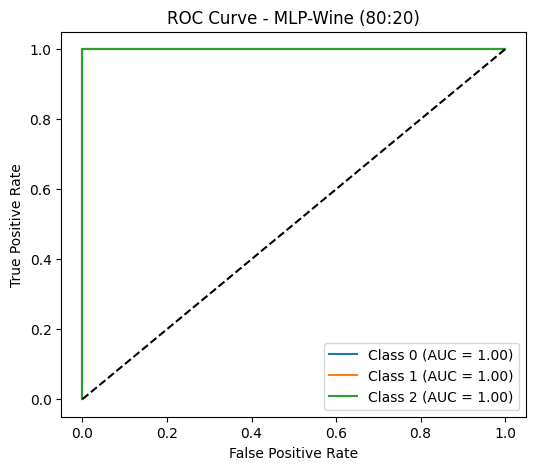

RandomForest train-test split: 80:20
[Default] RandomForest accuracy: 1.0000
[Tuned] RandomForest accuracy: 1.0000
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Evaluation Results:
                Model  Split  Accuracy  Precision  Recall  F1-score
23  RandomForest-Wine  80:20       1.0        1.0     1.0       1.0


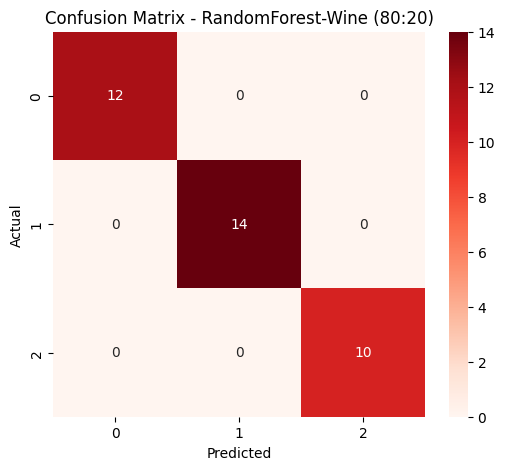

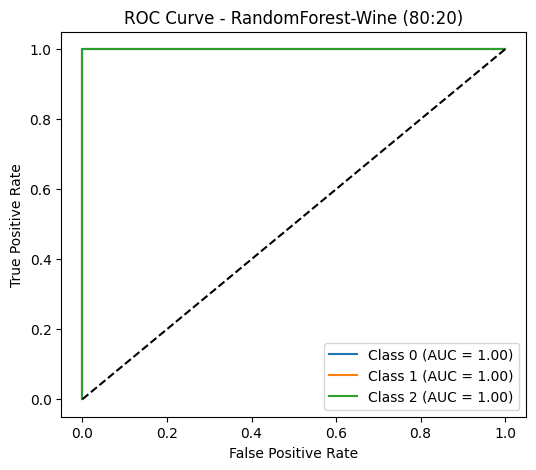

In [55]:
wine = load_wine()
results_wine = train_and_evaluate(wine.data, wine.target, "Wine")

# Digits

SVM-linear train-test split: 50:50
[Default] SVM-linear accuracy: 0.9711
[Tuned] SVM-linear accuracy: 0.9711
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
               Model  Split  Accuracy  Precision    Recall  F1-score
0  SVM-linear-Digits  50:50  0.971079   0.971747  0.971079  0.971038


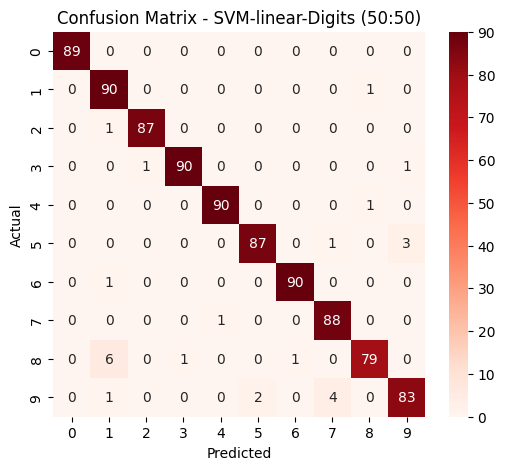

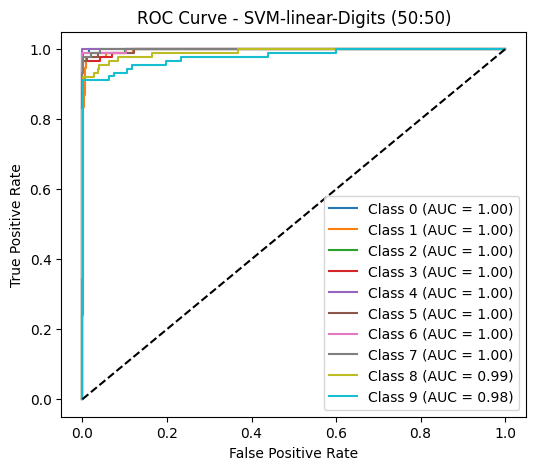

SVM-poly train-test split: 50:50
[Default] SVM-poly accuracy: 0.9277
[Tuned] SVM-poly accuracy: 0.9800
[Tuned] SVM-poly best params: {'C': 10, 'degree': 2, 'gamma': 'scale'}

Evaluation Results:
             Model  Split  Accuracy  Precision    Recall  F1-score
1  SVM-poly-Digits  50:50  0.979978   0.980149  0.979978   0.97998


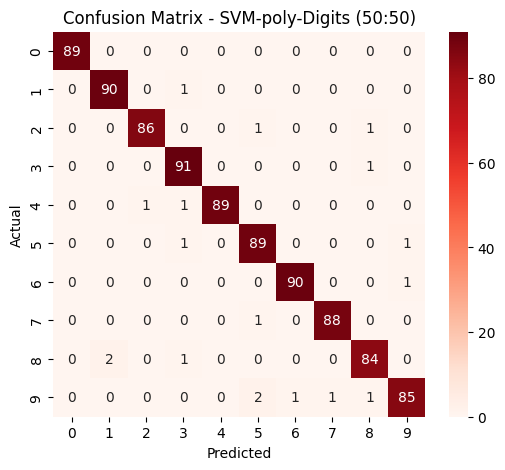

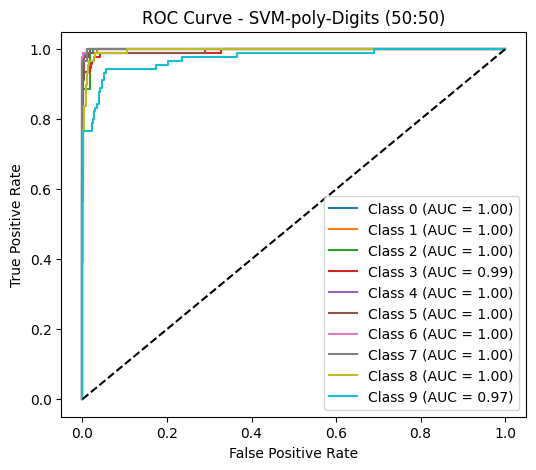

SVM-rbf train-test split: 50:50
[Default] SVM-rbf accuracy: 0.9711
[Tuned] SVM-rbf accuracy: 0.9711
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
            Model  Split  Accuracy  Precision    Recall  F1-score
2  SVM-rbf-Digits  50:50  0.971079   0.971858  0.971079  0.970991


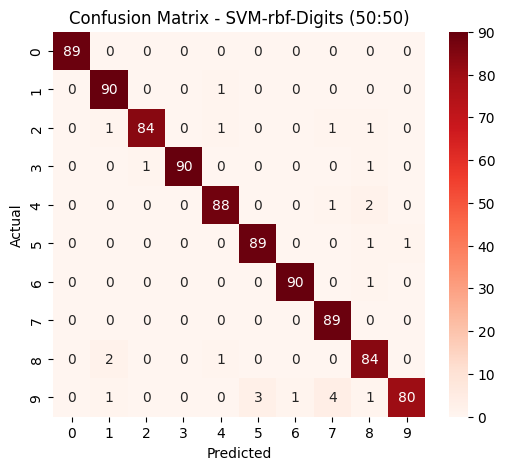

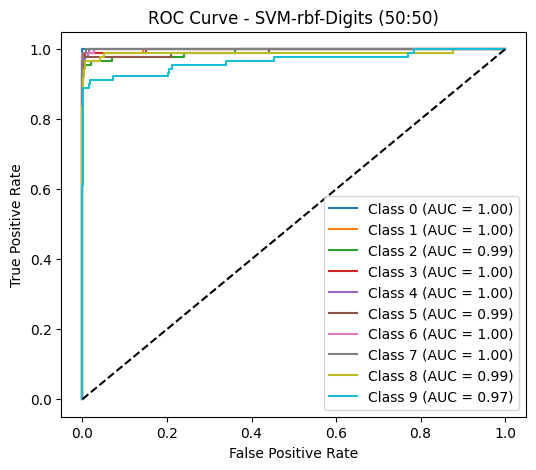

SVM-sigmoid train-test split: 50:50
[Default] SVM-sigmoid accuracy: 0.9444
[Tuned] SVM-sigmoid accuracy: 0.9444
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
                Model  Split  Accuracy  Precision    Recall  F1-score
3  SVM-sigmoid-Digits  50:50  0.944383   0.946306  0.944383  0.944679


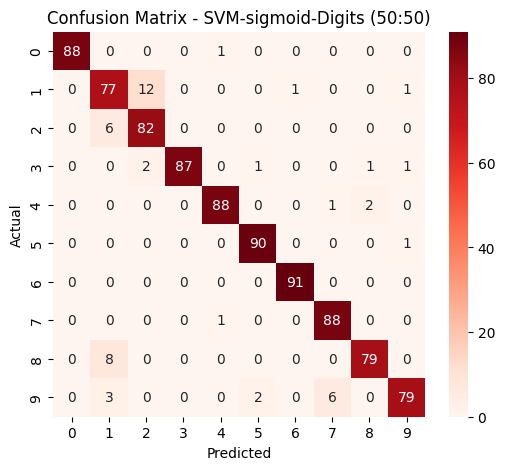

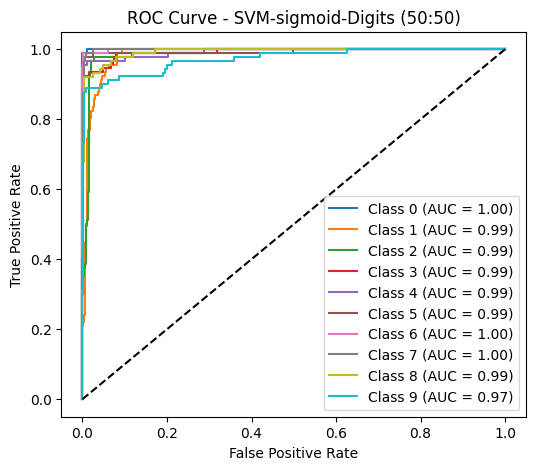

MLP train-test split: 50:50
[Default] MLP accuracy: 0.9711
[Tuned] MLP accuracy: 0.9711
[Tuned] MLP best params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 300, 'momentum': 0.8, 'solver': 'adam'}

Evaluation Results:
        Model  Split  Accuracy  Precision    Recall  F1-score
4  MLP-Digits  50:50  0.971079   0.971635  0.971079  0.971074


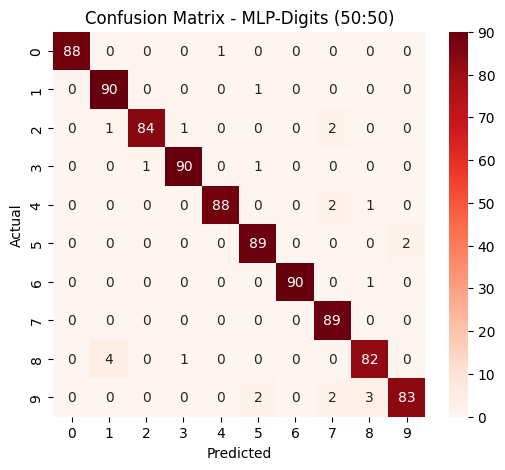

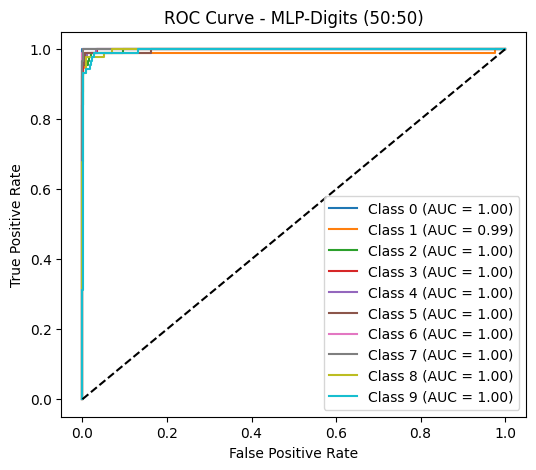

RandomForest train-test split: 50:50
[Default] RandomForest accuracy: 0.9577
[Tuned] RandomForest accuracy: 0.9577
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
5  RandomForest-Digits  50:50  0.957731    0.95919  0.957731  0.957678


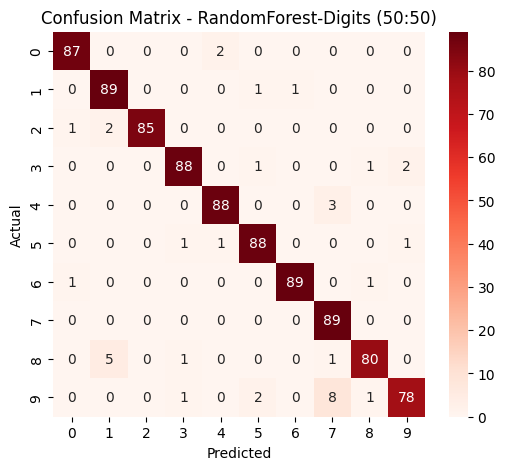

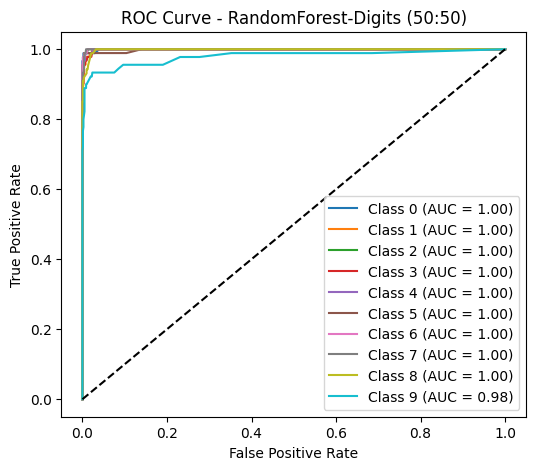

SVM-linear train-test split: 60:40
[Default] SVM-linear accuracy: 0.9708
[Tuned] SVM-linear accuracy: 0.9708
[Tuned] SVM-linear best params: {'C': 1}

Evaluation Results:
               Model  Split  Accuracy  Precision    Recall  F1-score
6  SVM-linear-Digits  60:40  0.970793    0.97208  0.970793  0.970928


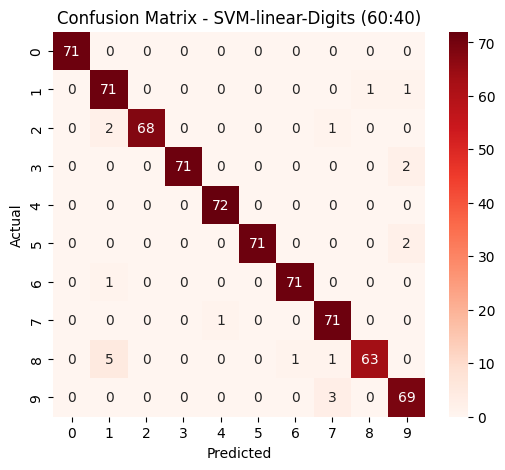

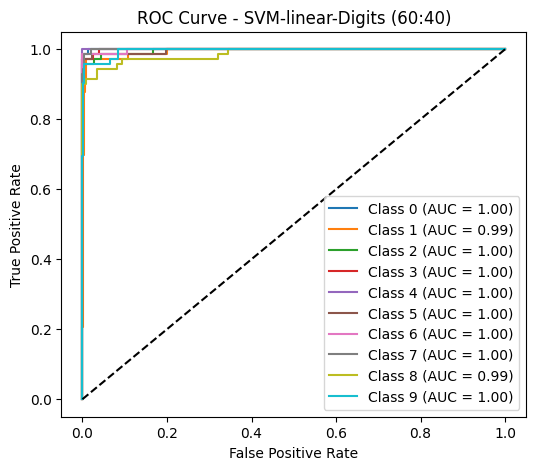

SVM-poly train-test split: 60:40
[Default] SVM-poly accuracy: 0.9471
[Tuned] SVM-poly accuracy: 0.9847
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
             Model  Split  Accuracy  Precision    Recall  F1-score
7  SVM-poly-Digits  60:40  0.984701   0.985469  0.984701  0.984861


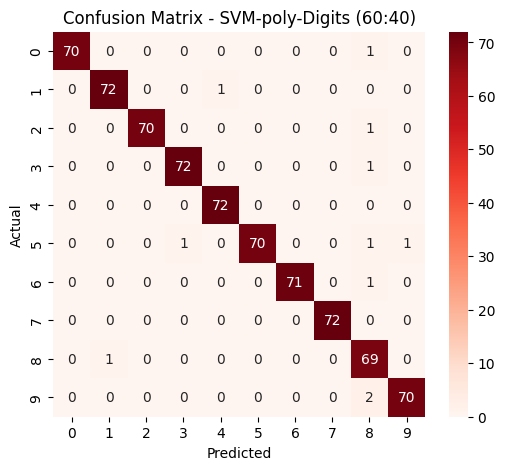

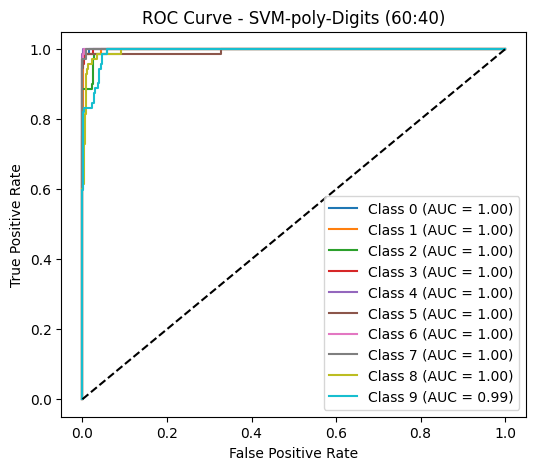

SVM-rbf train-test split: 60:40
[Default] SVM-rbf accuracy: 0.9833
[Tuned] SVM-rbf accuracy: 0.9819
[Tuned] SVM-rbf best params: {'C': 10, 'gamma': 'scale'}

Evaluation Results:
            Model  Split  Accuracy  Precision    Recall  F1-score
8  SVM-rbf-Digits  60:40  0.981919   0.982339  0.981919  0.981921


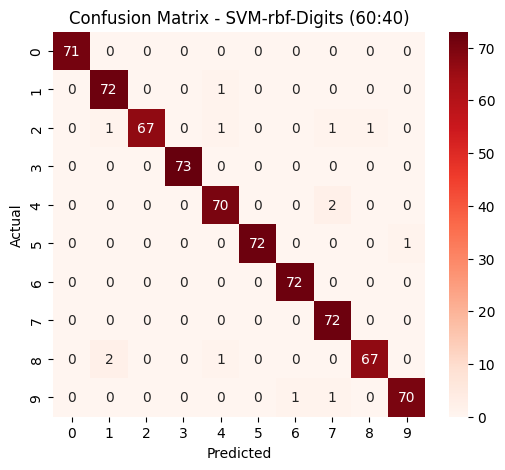

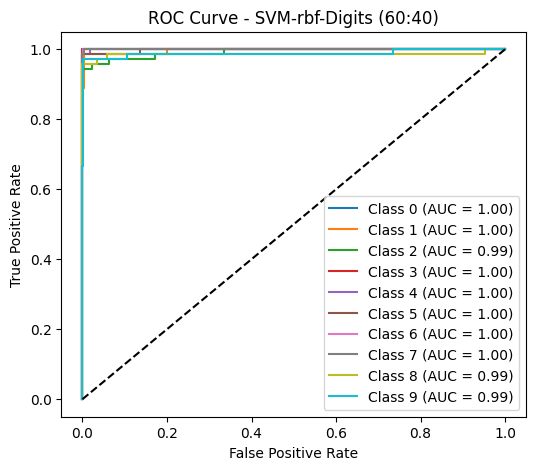

SVM-sigmoid train-test split: 60:40
[Default] SVM-sigmoid accuracy: 0.9332
[Tuned] SVM-sigmoid accuracy: 0.9374
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
                Model  Split  Accuracy  Precision    Recall  F1-score
9  SVM-sigmoid-Digits  60:40  0.937413   0.938421  0.937413  0.937338


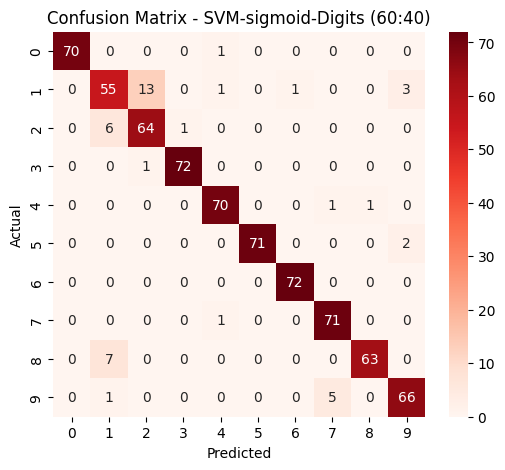

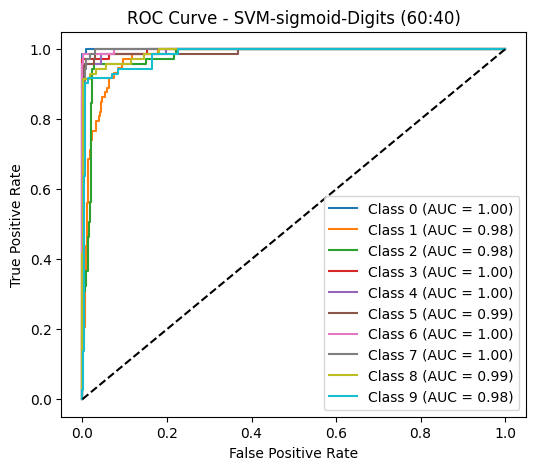

MLP train-test split: 60:40
[Default] MLP accuracy: 0.9722
[Tuned] MLP accuracy: 0.9736
[Tuned] MLP best params: {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'max_iter': 300, 'momentum': 0.8, 'solver': 'sgd'}

Evaluation Results:
         Model  Split  Accuracy  Precision    Recall  F1-score
10  MLP-Digits  60:40  0.973574   0.973867  0.973574  0.973555


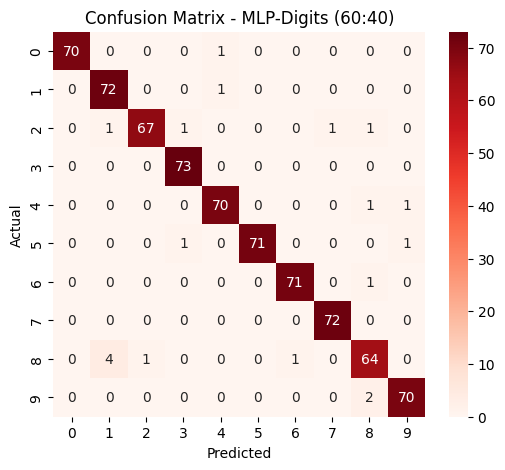

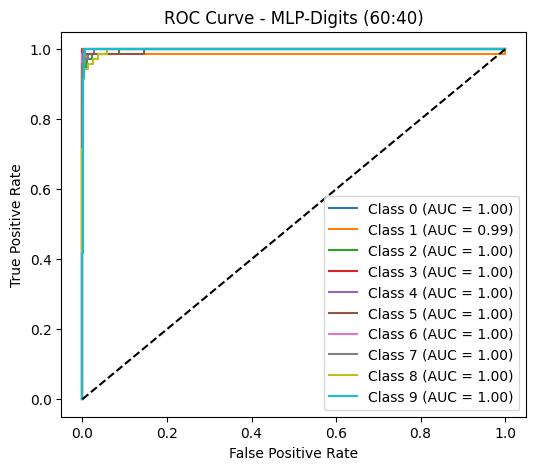

RandomForest train-test split: 60:40
[Default] RandomForest accuracy: 0.9666
[Tuned] RandomForest accuracy: 0.9638
[Tuned] RandomForest best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
11  RandomForest-Digits  60:40  0.963839   0.965183  0.963839  0.963804


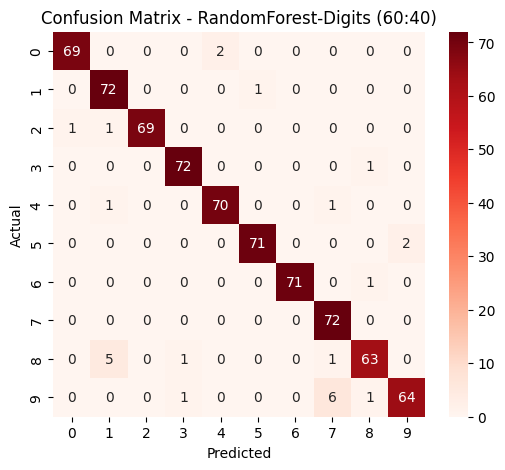

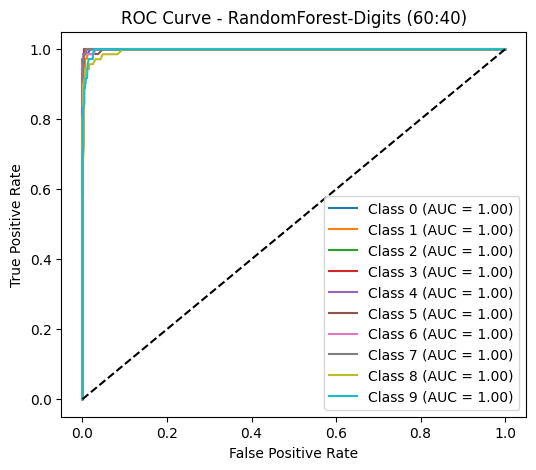

SVM-linear train-test split: 70:30
[Default] SVM-linear accuracy: 0.9796
[Tuned] SVM-linear accuracy: 0.9796
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
                Model  Split  Accuracy  Precision   Recall  F1-score
12  SVM-linear-Digits  70:30   0.97963   0.980555  0.97963  0.979534


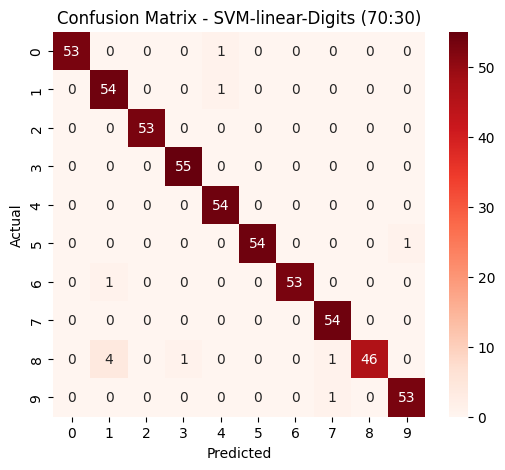

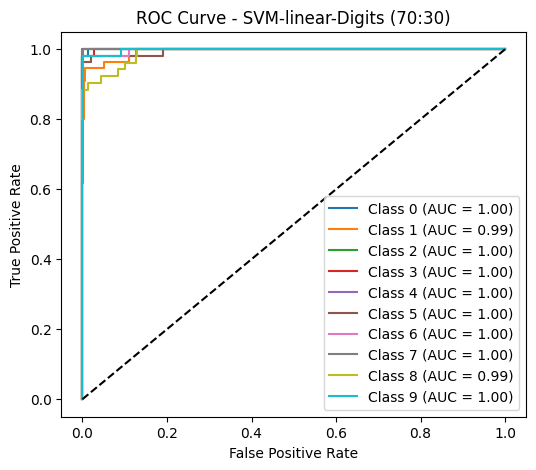

SVM-poly train-test split: 70:30
[Default] SVM-poly accuracy: 0.9667
[Tuned] SVM-poly accuracy: 0.9759
[Tuned] SVM-poly best params: {'C': 10, 'degree': 2, 'gamma': 'scale'}

Evaluation Results:
              Model  Split  Accuracy  Precision    Recall  F1-score
13  SVM-poly-Digits  70:30  0.975926   0.976509  0.975926  0.975965


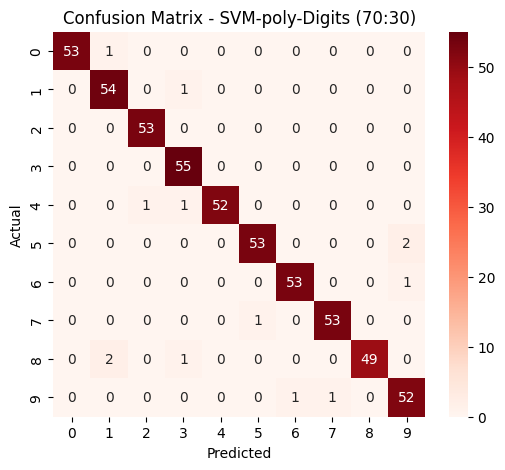

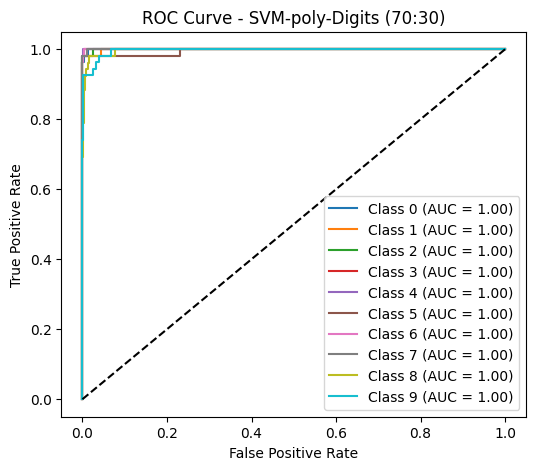

SVM-rbf train-test split: 70:30
[Default] SVM-rbf accuracy: 0.9833
[Tuned] SVM-rbf accuracy: 0.9815
[Tuned] SVM-rbf best params: {'C': 10, 'gamma': 'scale'}

Evaluation Results:
             Model  Split  Accuracy  Precision    Recall  F1-score
14  SVM-rbf-Digits  70:30  0.981481   0.982006  0.981481  0.981466


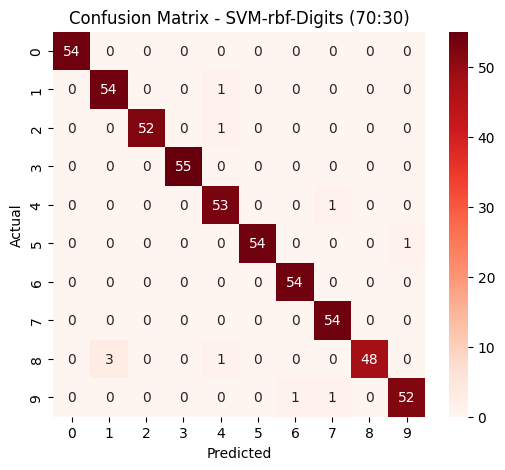

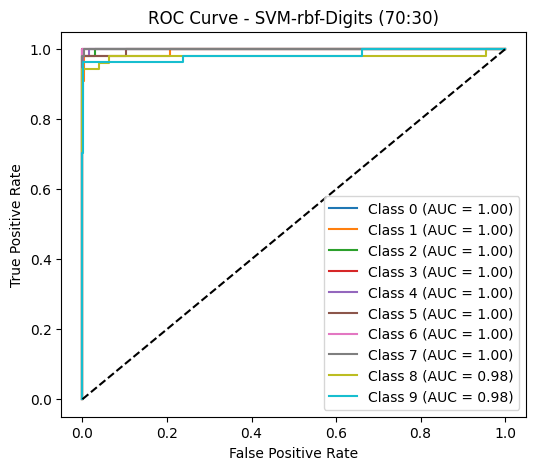

SVM-sigmoid train-test split: 70:30
[Default] SVM-sigmoid accuracy: 0.9389
[Tuned] SVM-sigmoid accuracy: 0.9426
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
15  SVM-sigmoid-Digits  70:30  0.942593   0.944362  0.942593  0.942487


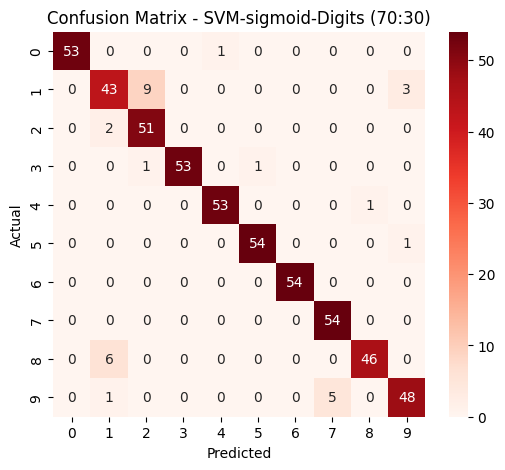

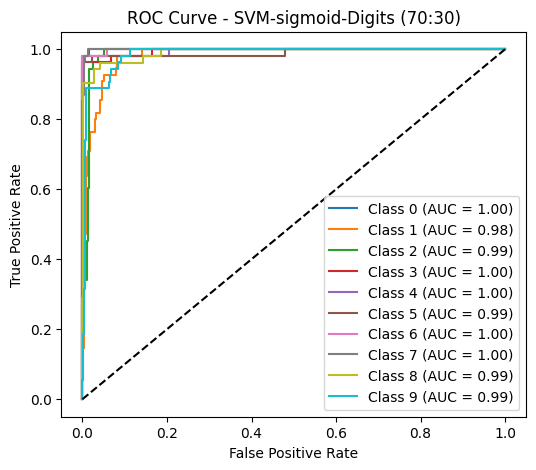

MLP train-test split: 70:30
[Default] MLP accuracy: 0.9796
[Tuned] MLP accuracy: 0.9796
[Tuned] MLP best params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 300, 'momentum': 0.8, 'solver': 'adam'}

Evaluation Results:
         Model  Split  Accuracy  Precision   Recall  F1-score
16  MLP-Digits  70:30   0.97963   0.979749  0.97963  0.979624


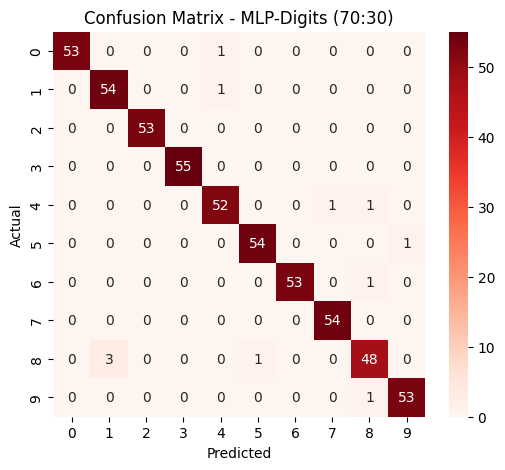

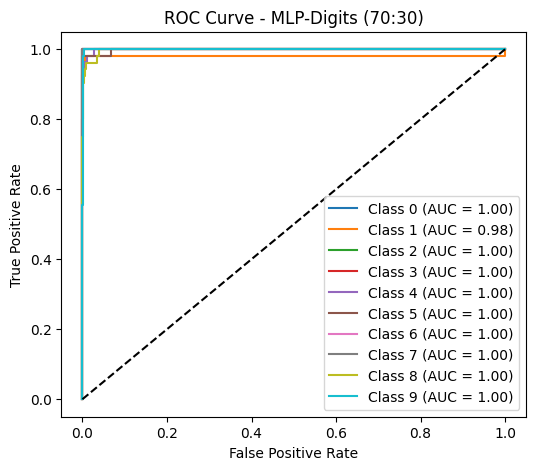

RandomForest train-test split: 70:30
[Default] RandomForest accuracy: 0.9685
[Tuned] RandomForest accuracy: 0.9648
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
17  RandomForest-Digits  70:30  0.964815   0.966629  0.964815  0.964849


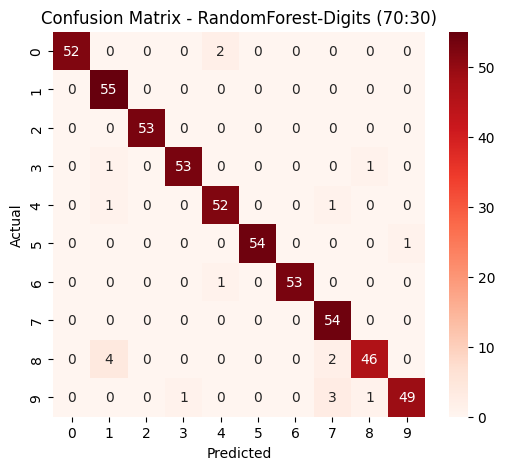

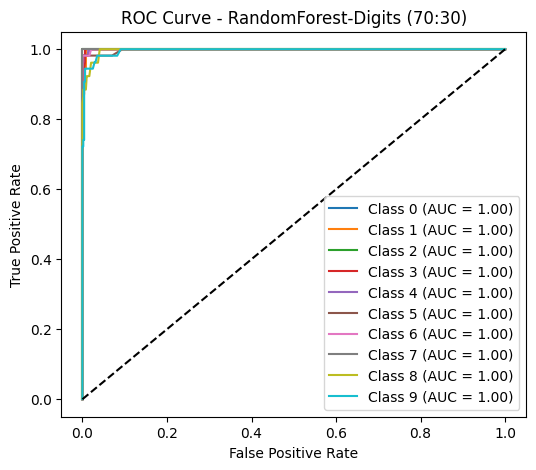

SVM-linear train-test split: 80:20
[Default] SVM-linear accuracy: 0.9750
[Tuned] SVM-linear accuracy: 0.9750
[Tuned] SVM-linear best params: {'C': 1}

Evaluation Results:
                Model  Split  Accuracy  Precision  Recall  F1-score
18  SVM-linear-Digits  80:20     0.975   0.975407   0.975  0.974897


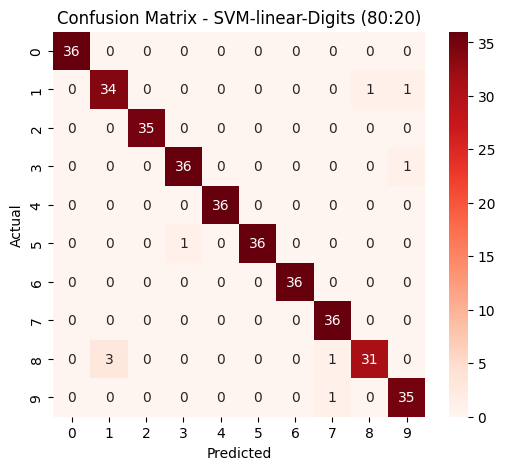

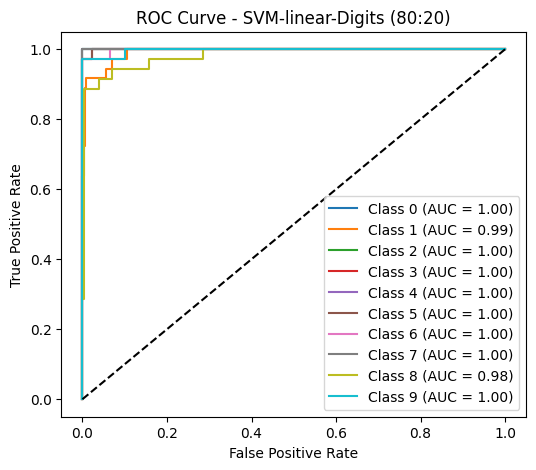

SVM-poly train-test split: 80:20
[Default] SVM-poly accuracy: 0.9722
[Tuned] SVM-poly accuracy: 0.9944
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
              Model  Split  Accuracy  Precision    Recall  F1-score
19  SVM-poly-Digits  80:20  0.994444   0.994597  0.994444  0.994444


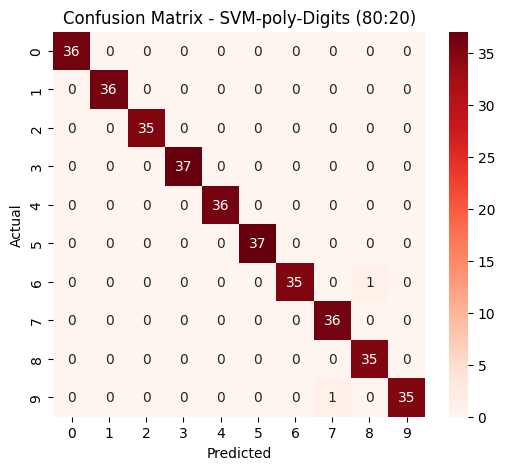

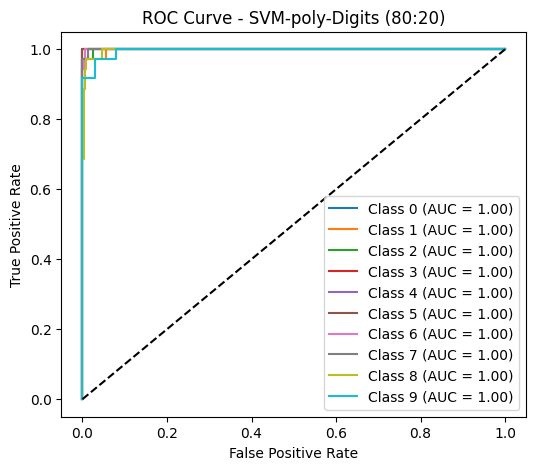

SVM-rbf train-test split: 80:20
[Default] SVM-rbf accuracy: 0.9750
[Tuned] SVM-rbf accuracy: 0.9833
[Tuned] SVM-rbf best params: {'C': 10, 'gamma': 0.01}

Evaluation Results:
             Model  Split  Accuracy  Precision    Recall  F1-score
20  SVM-rbf-Digits  80:20  0.983333   0.983851  0.983333  0.983323


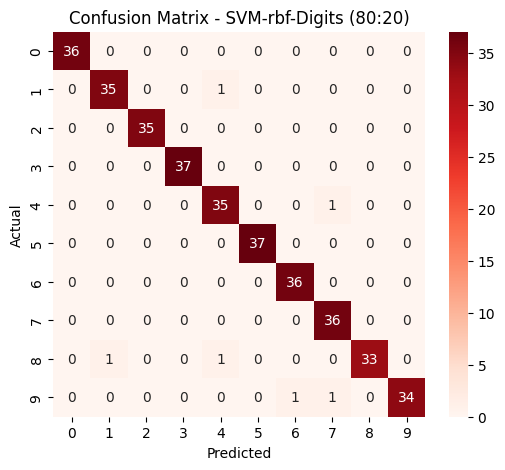

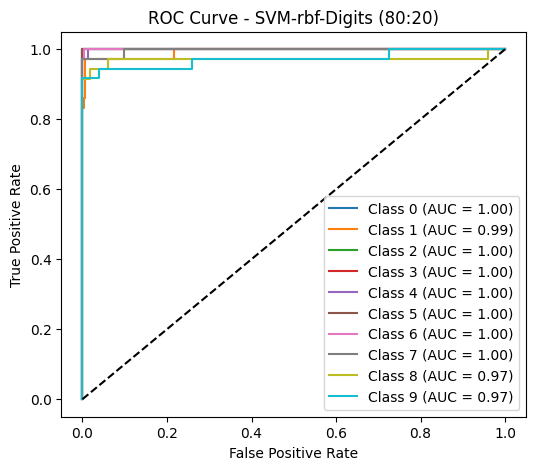

SVM-sigmoid train-test split: 80:20
[Default] SVM-sigmoid accuracy: 0.9389
[Tuned] SVM-sigmoid accuracy: 0.9472
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
21  SVM-sigmoid-Digits  80:20  0.947222   0.948916  0.947222  0.946885


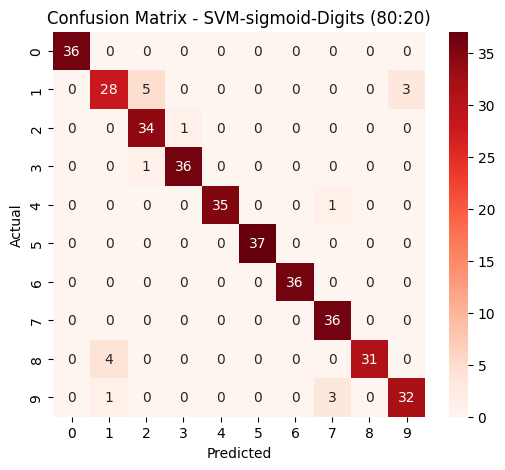

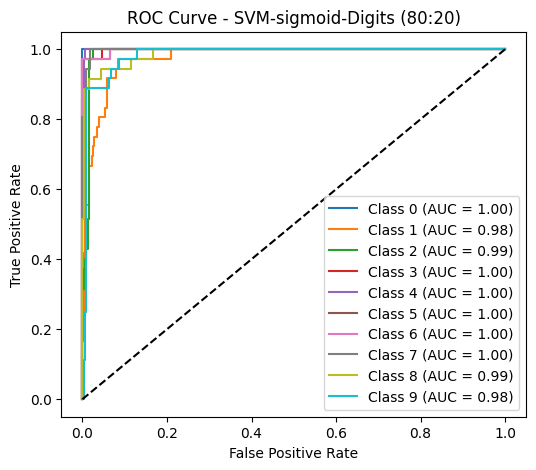

MLP train-test split: 80:20
[Default] MLP accuracy: 0.9750
[Tuned] MLP accuracy: 0.9806
[Tuned] MLP best params: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 300, 'momentum': 0.8, 'solver': 'adam'}

Evaluation Results:
         Model  Split  Accuracy  Precision    Recall  F1-score
22  MLP-Digits  80:20  0.980556   0.981027  0.980556    0.9805


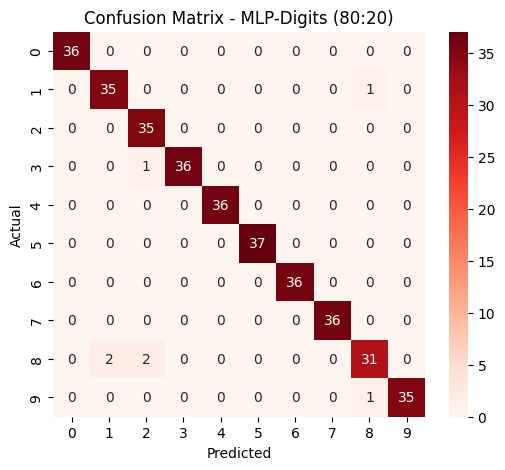

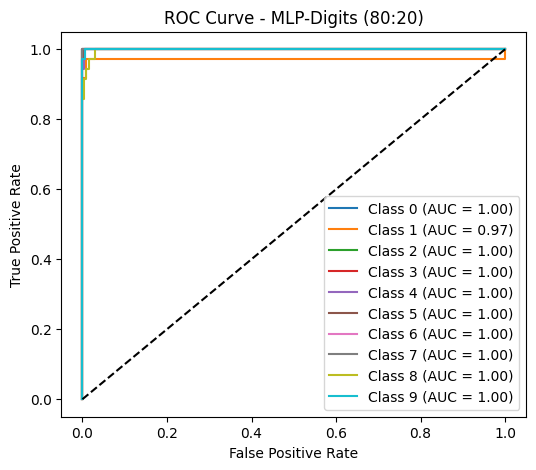

RandomForest train-test split: 80:20
[Default] RandomForest accuracy: 0.9639
[Tuned] RandomForest accuracy: 0.9639
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
23  RandomForest-Digits  80:20  0.963889   0.964432  0.963889   0.96361


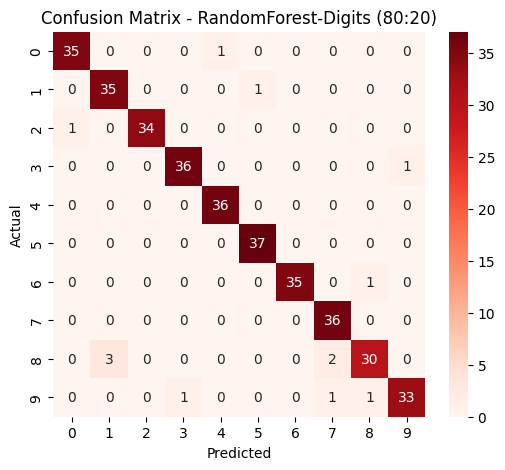

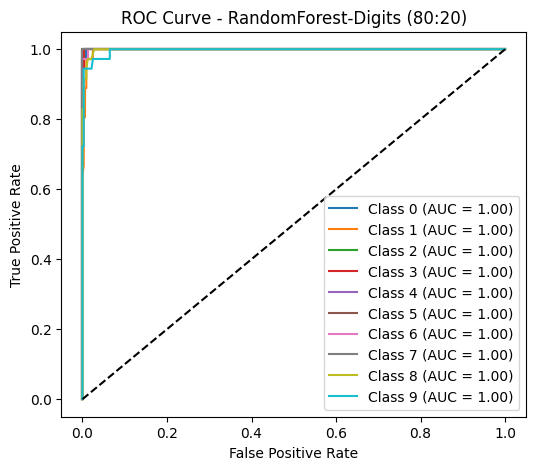

In [56]:
digits = load_digits()
results_digits = train_and_evaluate(digits.data, digits.target, "Digits")

# PCA

[Wine-PCA] Reduced dimensionality: 13 -> 10
SVM-linear train-test split: 50:50
[Default] SVM-linear accuracy: 0.9663
[Tuned] SVM-linear accuracy: 0.9663
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
0  SVM-linear-Wine-PCA  50:50  0.966292   0.970037  0.966292  0.966529


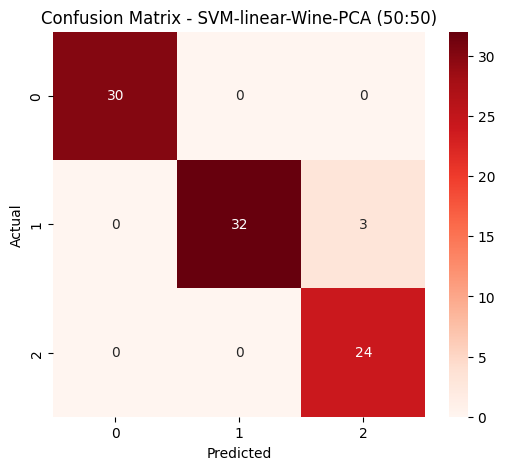

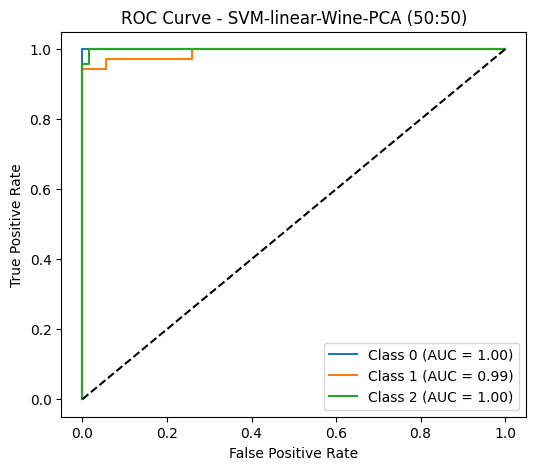

SVM-poly train-test split: 50:50
[Default] SVM-poly accuracy: 0.9775
[Tuned] SVM-poly accuracy: 0.9551
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
               Model  Split  Accuracy  Precision    Recall  F1-score
1  SVM-poly-Wine-PCA  50:50  0.955056    0.95857  0.955056  0.954611


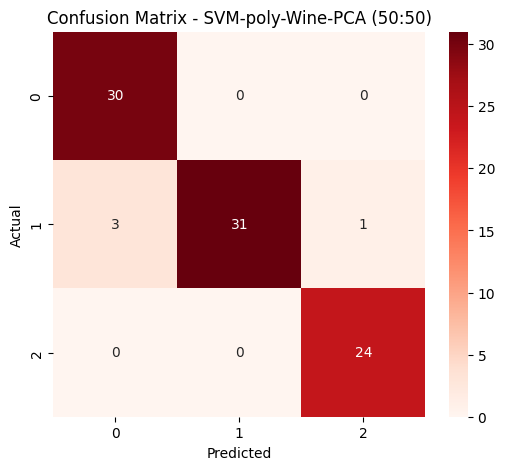

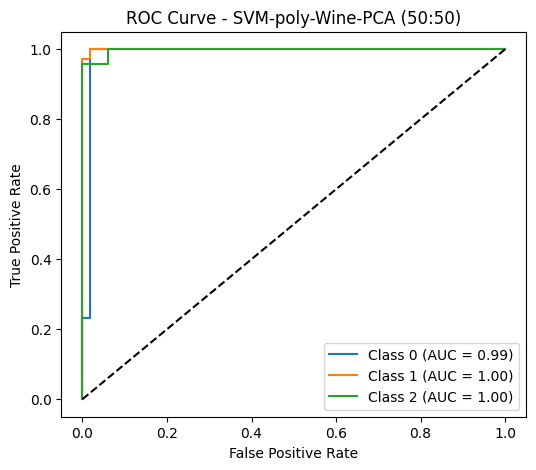

SVM-rbf train-test split: 50:50
[Default] SVM-rbf accuracy: 0.9888
[Tuned] SVM-rbf accuracy: 0.9888
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
              Model  Split  Accuracy  Precision    Recall  F1-score
2  SVM-rbf-Wine-PCA  50:50  0.988764   0.989213  0.988764  0.988797


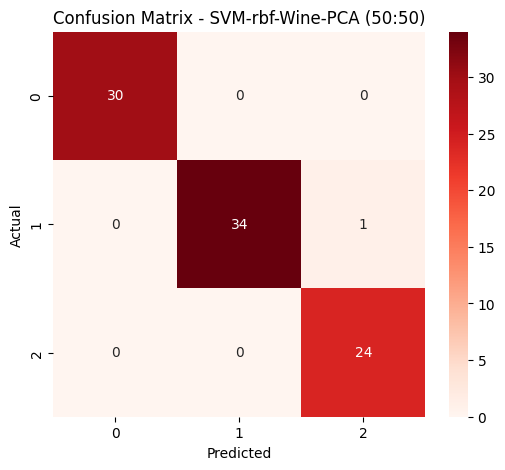

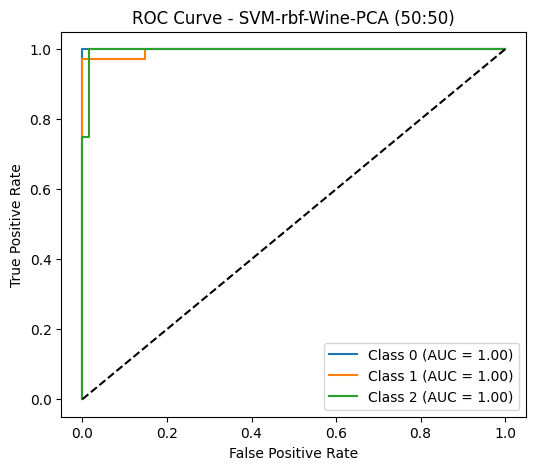

SVM-sigmoid train-test split: 50:50
[Default] SVM-sigmoid accuracy: 0.8989
[Tuned] SVM-sigmoid accuracy: 0.8989
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
3  SVM-sigmoid-Wine-PCA  50:50  0.898876   0.905431  0.898876  0.899636


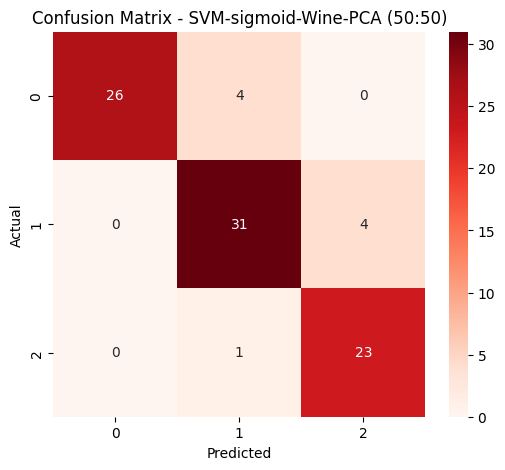

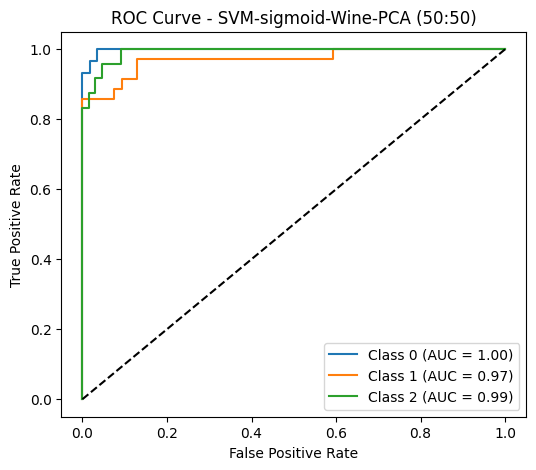

MLP train-test split: 50:50
[Default] MLP accuracy: 0.9775


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[Tuned] MLP accuracy: 0.9775
[Tuned] MLP best params: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 300, 'momentum': 0.8, 'solver': 'sgd'}

Evaluation Results:
          Model  Split  Accuracy  Precision    Recall  F1-score
4  MLP-Wine-PCA  50:50  0.977528    0.97834  0.977528  0.977404


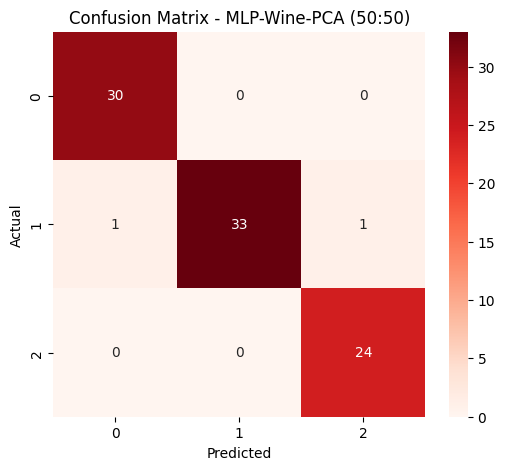

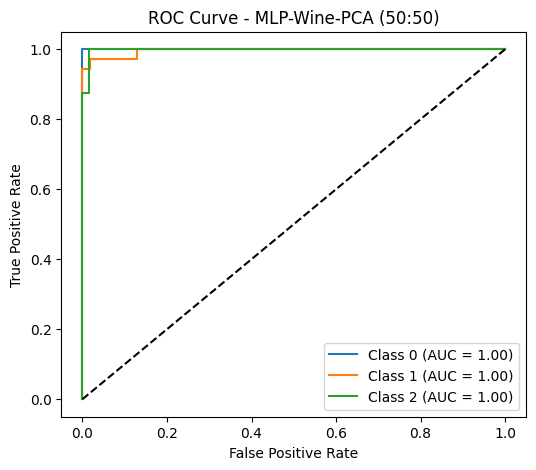

RandomForest train-test split: 50:50
[Default] RandomForest accuracy: 0.9101
[Tuned] RandomForest accuracy: 0.9101
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
                   Model  Split  Accuracy  Precision    Recall  F1-score
5  RandomForest-Wine-PCA  50:50  0.910112   0.910236  0.910112   0.90998


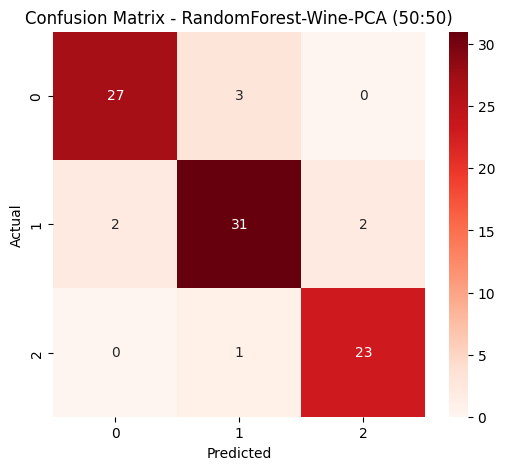

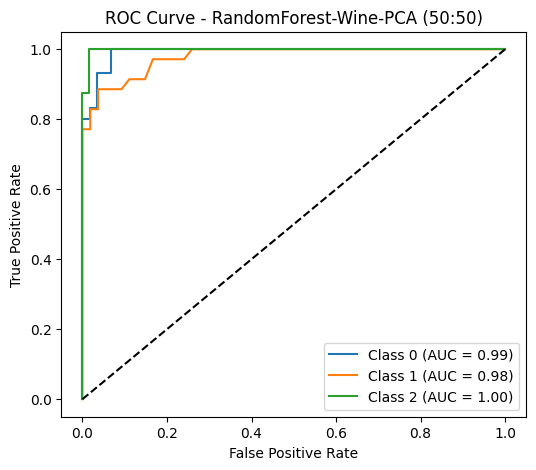

SVM-linear train-test split: 60:40
[Default] SVM-linear accuracy: 0.9861
[Tuned] SVM-linear accuracy: 0.9861
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
6  SVM-linear-Wine-PCA  60:40  0.986111   0.986806  0.986111  0.986167


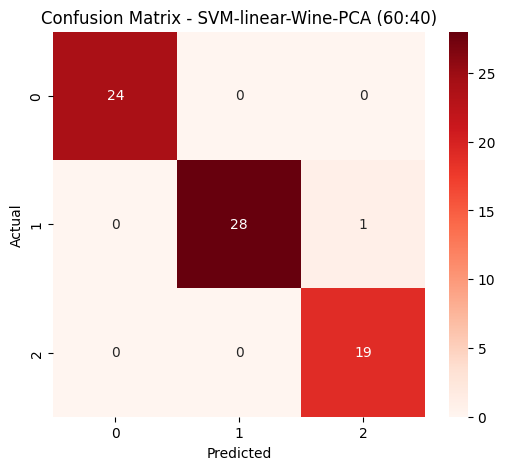

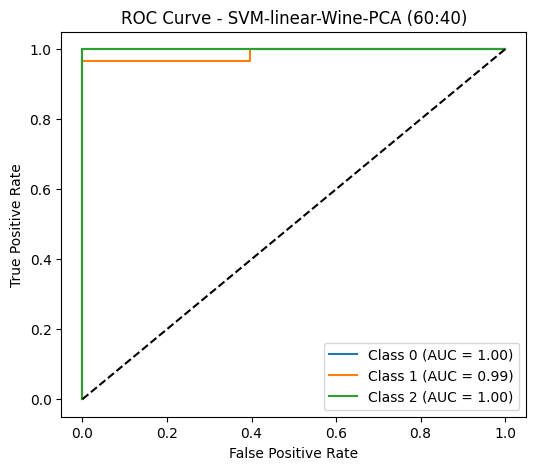

SVM-poly train-test split: 60:40
[Default] SVM-poly accuracy: 0.9861
[Tuned] SVM-poly accuracy: 0.9583
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
               Model  Split  Accuracy  Precision    Recall  F1-score
7  SVM-poly-Wine-PCA  60:40  0.958333   0.962963  0.958333  0.958422


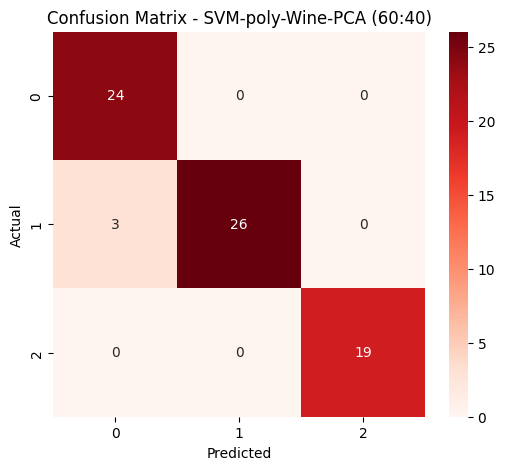

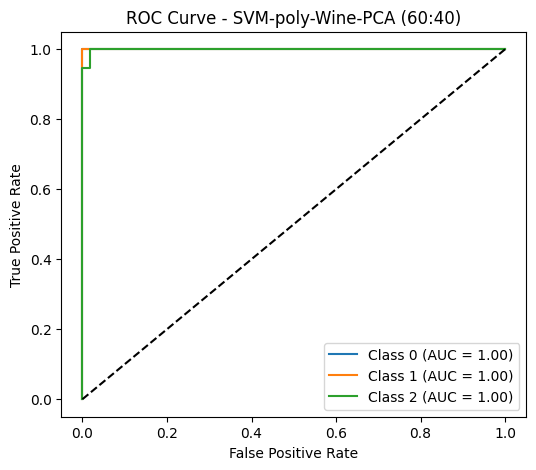

SVM-rbf train-test split: 60:40
[Default] SVM-rbf accuracy: 0.9861
[Tuned] SVM-rbf accuracy: 0.9861
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
              Model  Split  Accuracy  Precision    Recall  F1-score
8  SVM-rbf-Wine-PCA  60:40  0.986111   0.986806  0.986111  0.986167


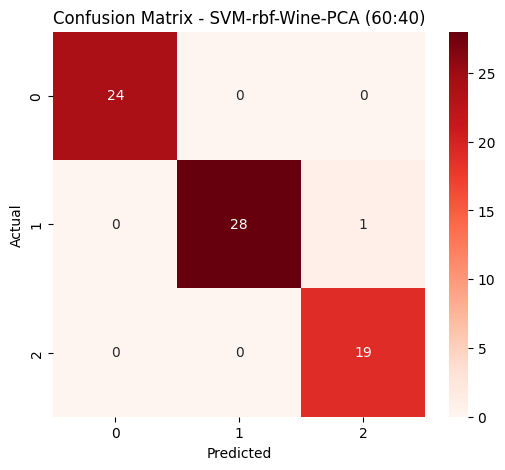

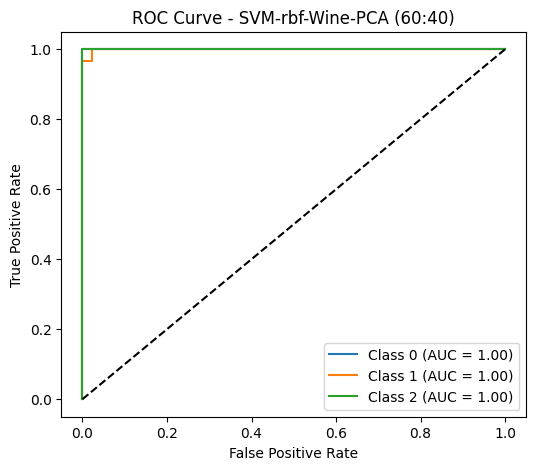

SVM-sigmoid train-test split: 60:40
[Default] SVM-sigmoid accuracy: 0.9861
[Tuned] SVM-sigmoid accuracy: 0.9861
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
9  SVM-sigmoid-Wine-PCA  60:40  0.986111   0.986806  0.986111  0.986167


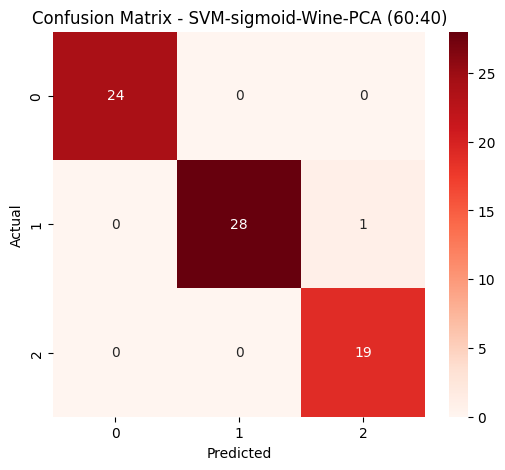

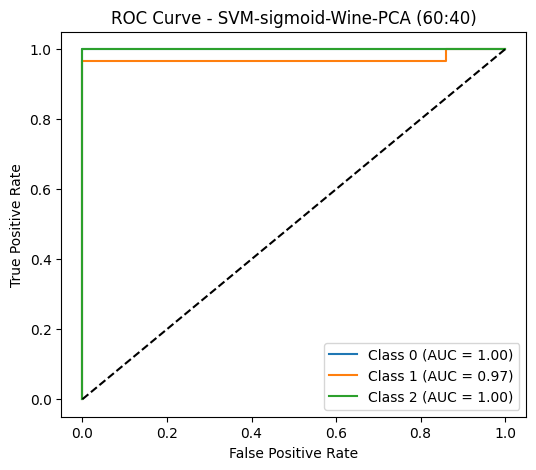

MLP train-test split: 60:40
[Default] MLP accuracy: 0.9722


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[Tuned] MLP accuracy: 0.9722
[Tuned] MLP best params: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 300, 'momentum': 0.9, 'solver': 'sgd'}

Evaluation Results:
           Model  Split  Accuracy  Precision    Recall  F1-score
10  MLP-Wine-PCA  60:40  0.972222   0.973472  0.972222  0.972046


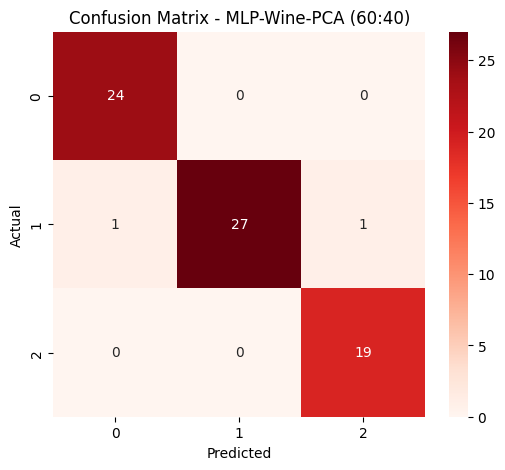

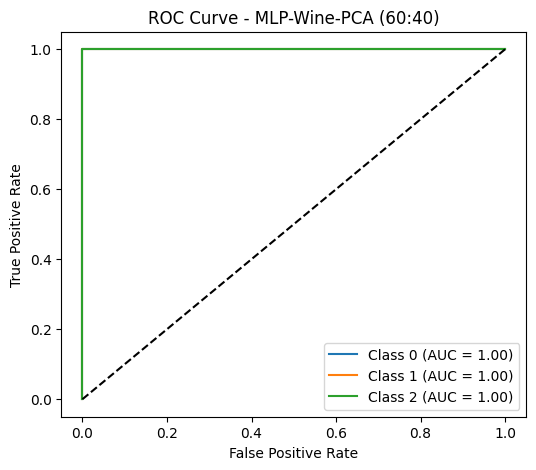

RandomForest train-test split: 60:40
[Default] RandomForest accuracy: 0.9167
[Tuned] RandomForest accuracy: 0.9167
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
                    Model  Split  Accuracy  Precision    Recall  F1-score
11  RandomForest-Wine-PCA  60:40  0.916667   0.918333  0.916667  0.917188


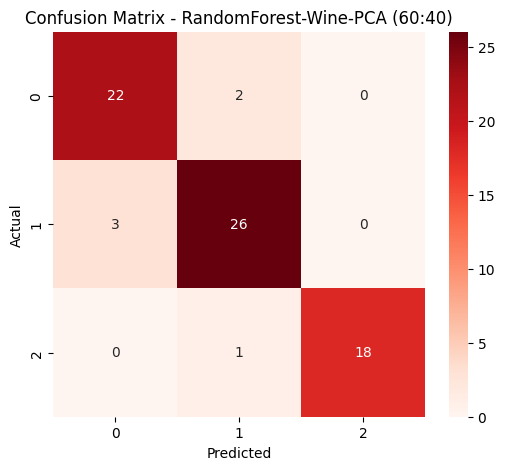

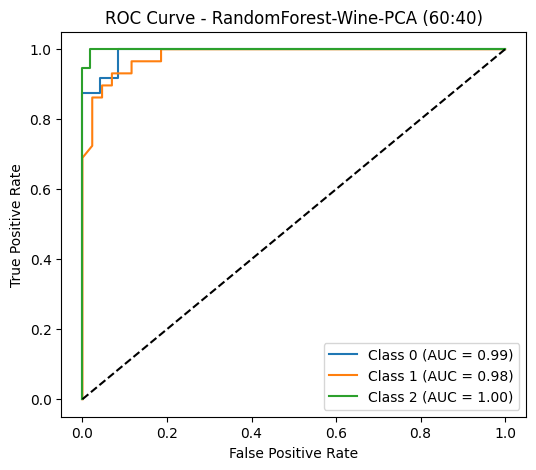

SVM-linear train-test split: 70:30
[Default] SVM-linear accuracy: 0.9815
[Tuned] SVM-linear accuracy: 0.9630
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
12  SVM-linear-Wine-PCA  70:30  0.962963    0.96732  0.962963  0.963194


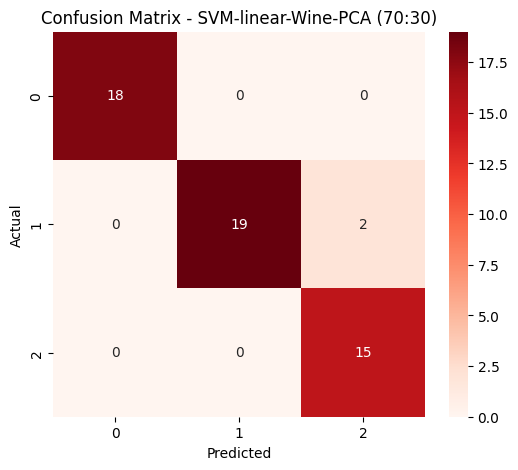

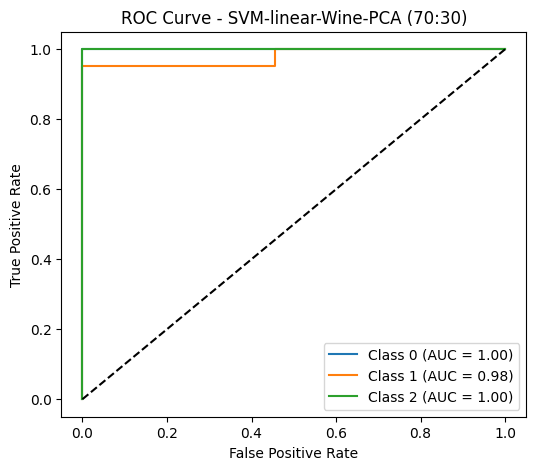

SVM-poly train-test split: 70:30
[Default] SVM-poly accuracy: 0.9815
[Tuned] SVM-poly accuracy: 0.9630
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
                Model  Split  Accuracy  Precision    Recall  F1-score
13  SVM-poly-Wine-PCA  70:30  0.962963   0.965095  0.962963  0.962586


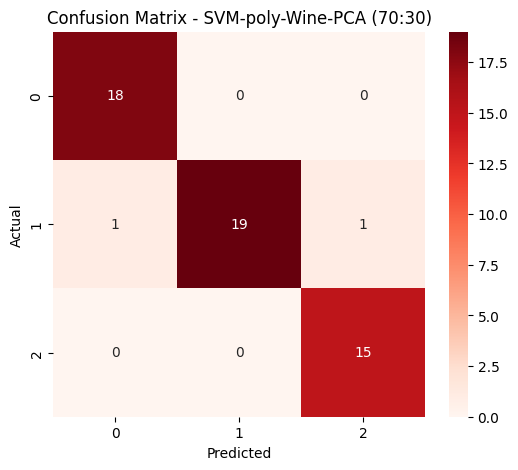

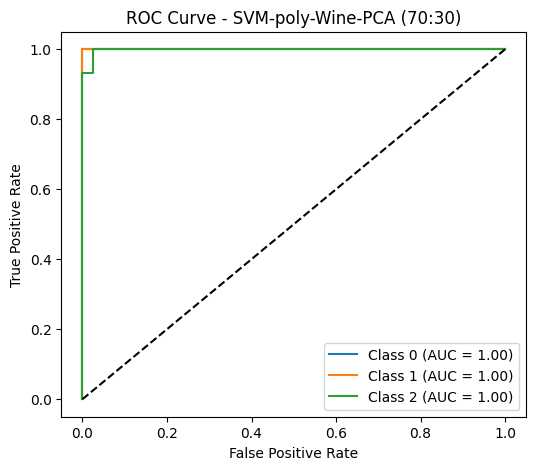

SVM-rbf train-test split: 70:30
[Default] SVM-rbf accuracy: 0.9630
[Tuned] SVM-rbf accuracy: 0.9630
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
               Model  Split  Accuracy  Precision    Recall  F1-score
14  SVM-rbf-Wine-PCA  70:30  0.962963   0.962963  0.962963  0.962963


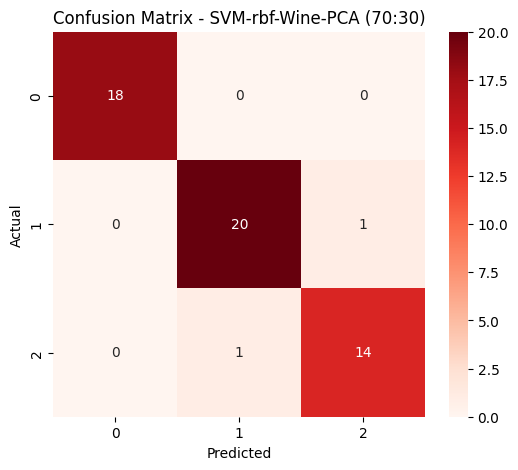

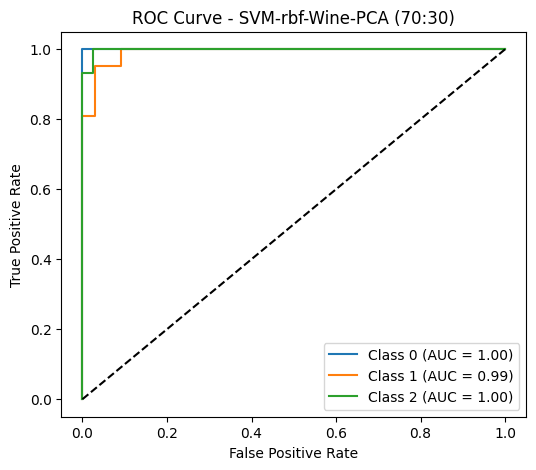

SVM-sigmoid train-test split: 70:30
[Default] SVM-sigmoid accuracy: 0.9630
[Tuned] SVM-sigmoid accuracy: 0.9630
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
                   Model  Split  Accuracy  Precision    Recall  F1-score
15  SVM-sigmoid-Wine-PCA  70:30  0.962963    0.96732  0.962963  0.963194


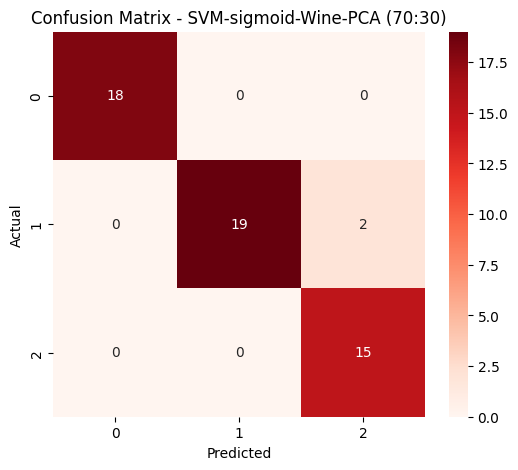

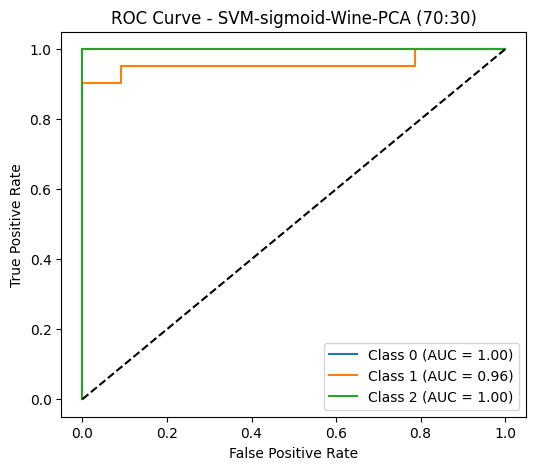

MLP train-test split: 70:30
[Default] MLP accuracy: 0.9630
[Tuned] MLP accuracy: 0.9815
[Tuned] MLP best params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 300, 'momentum': 0.8, 'solver': 'adam'}

Evaluation Results:
           Model  Split  Accuracy  Precision    Recall  F1-score
16  MLP-Wine-PCA  70:30  0.981481   0.982639  0.981481  0.981554


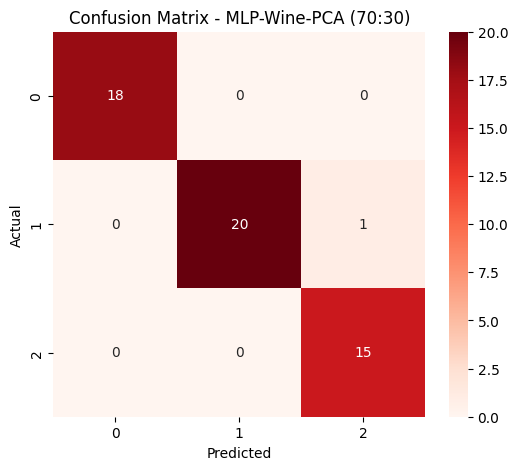

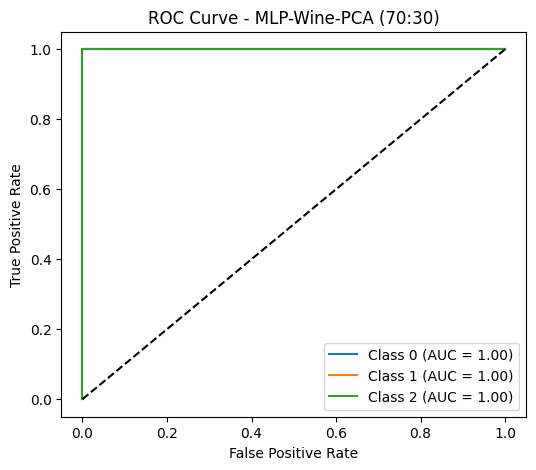

RandomForest train-test split: 70:30
[Default] RandomForest accuracy: 0.9074
[Tuned] RandomForest accuracy: 0.9074
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
                    Model  Split  Accuracy  Precision    Recall  F1-score
17  RandomForest-Wine-PCA  70:30  0.907407   0.909933  0.907407  0.908165


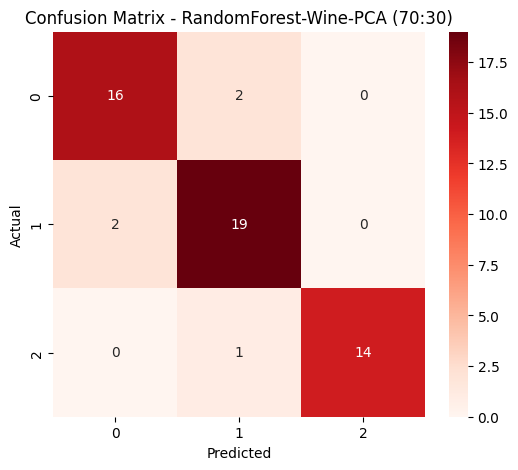

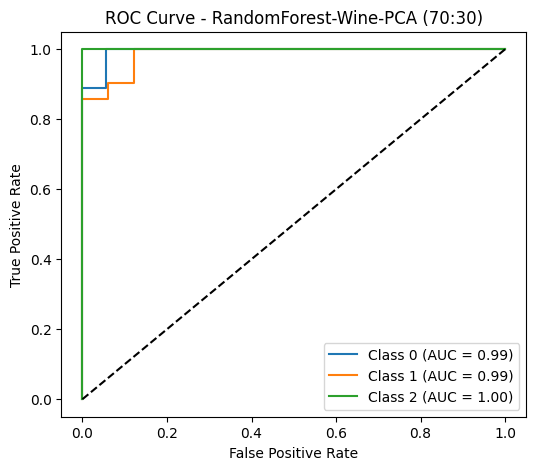

SVM-linear train-test split: 80:20
[Default] SVM-linear accuracy: 0.9722
[Tuned] SVM-linear accuracy: 0.9722
[Tuned] SVM-linear best params: {'C': 1}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
18  SVM-linear-Wine-PCA  80:20  0.972222   0.974074  0.972222   0.97197


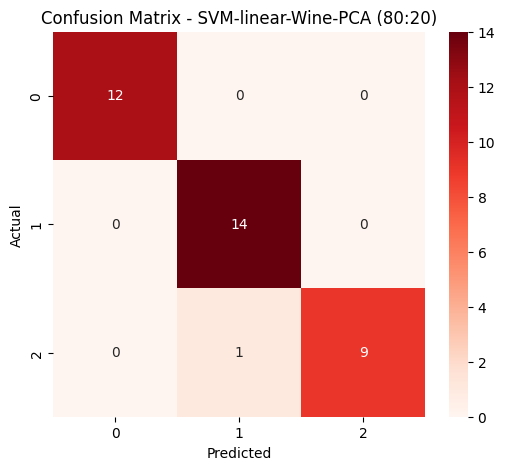

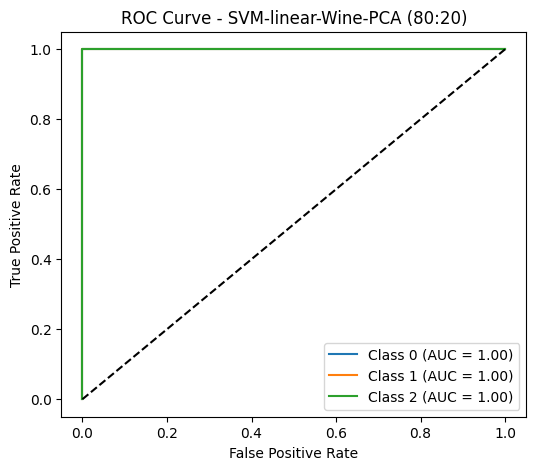

SVM-poly train-test split: 80:20
[Default] SVM-poly accuracy: 1.0000
[Tuned] SVM-poly accuracy: 0.9722
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
                Model  Split  Accuracy  Precision    Recall  F1-score
19  SVM-poly-Wine-PCA  80:20  0.972222   0.974359  0.972222  0.972263


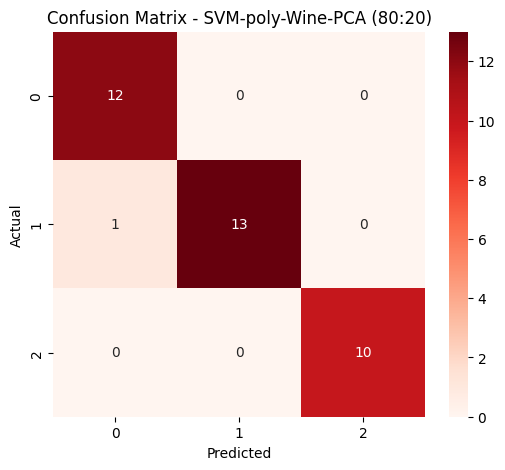

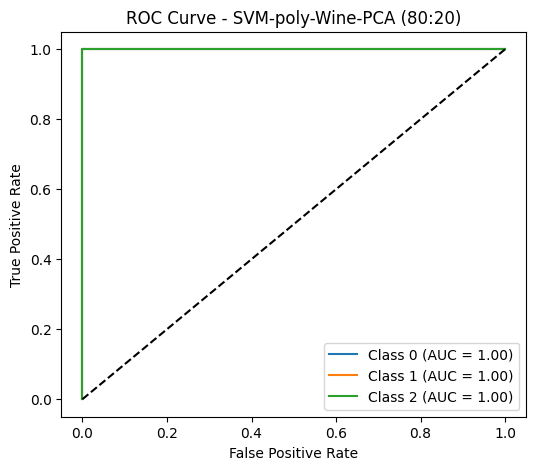

SVM-rbf train-test split: 80:20
[Default] SVM-rbf accuracy: 1.0000
[Tuned] SVM-rbf accuracy: 1.0000
[Tuned] SVM-rbf best params: {'C': 1, 'gamma': 0.01}

Evaluation Results:
               Model  Split  Accuracy  Precision  Recall  F1-score
20  SVM-rbf-Wine-PCA  80:20       1.0        1.0     1.0       1.0


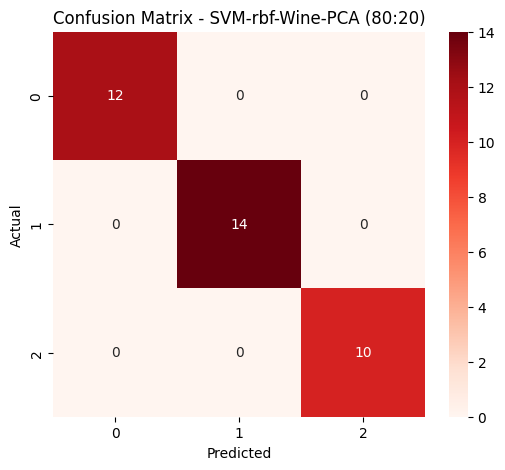

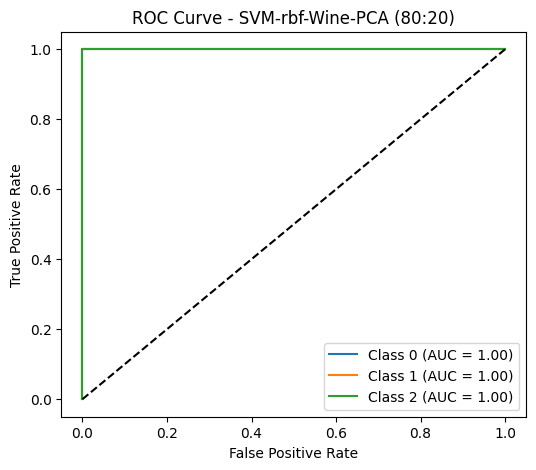

SVM-sigmoid train-test split: 80:20
[Default] SVM-sigmoid accuracy: 0.9722
[Tuned] SVM-sigmoid accuracy: 0.9722
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
                   Model  Split  Accuracy  Precision    Recall  F1-score
21  SVM-sigmoid-Wine-PCA  80:20  0.972222   0.974747  0.972222  0.972369


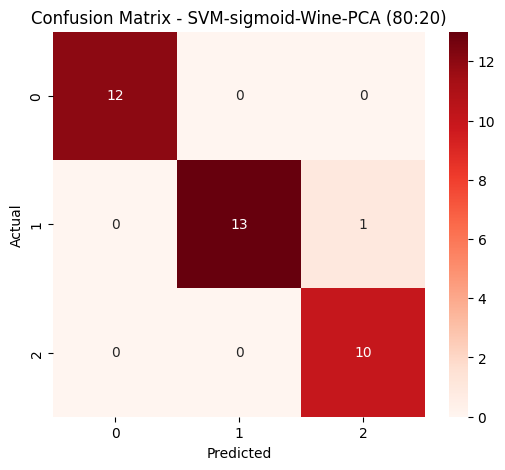

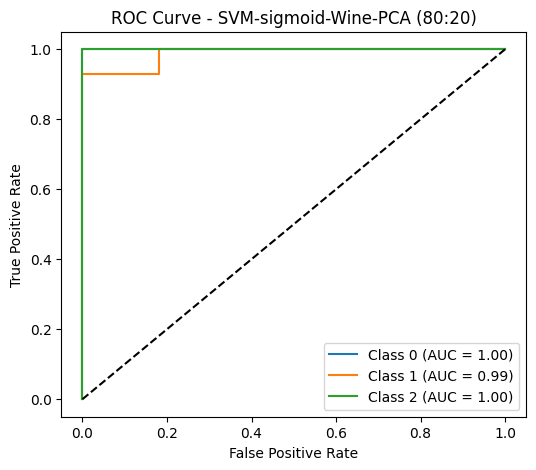

MLP train-test split: 80:20
[Default] MLP accuracy: 1.0000


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[Tuned] MLP accuracy: 1.0000
[Tuned] MLP best params: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'max_iter': 300, 'momentum': 0.9, 'solver': 'sgd'}

Evaluation Results:
           Model  Split  Accuracy  Precision  Recall  F1-score
22  MLP-Wine-PCA  80:20       1.0        1.0     1.0       1.0


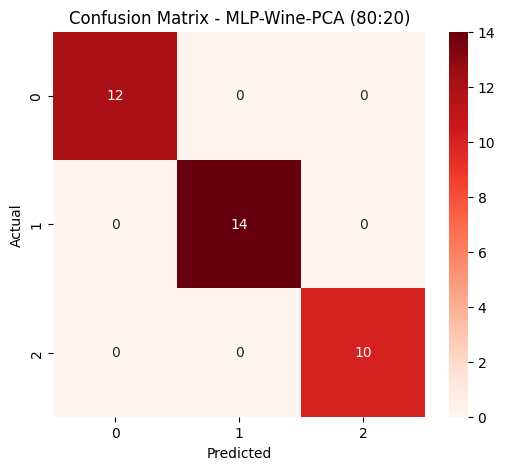

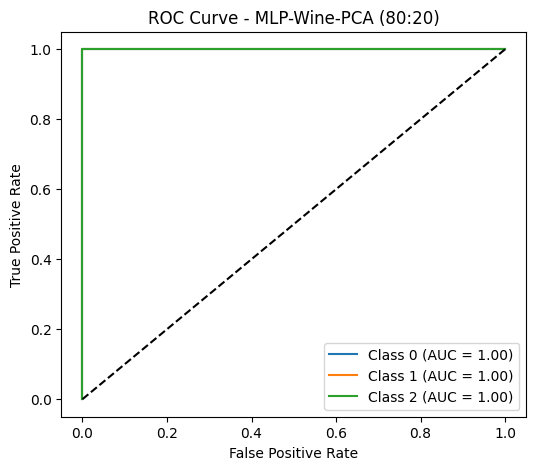

RandomForest train-test split: 80:20
[Default] RandomForest accuracy: 0.9444
[Tuned] RandomForest accuracy: 0.9444
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
                    Model  Split  Accuracy  Precision    Recall  F1-score
23  RandomForest-Wine-PCA  80:20  0.944444   0.944444  0.944444  0.944444


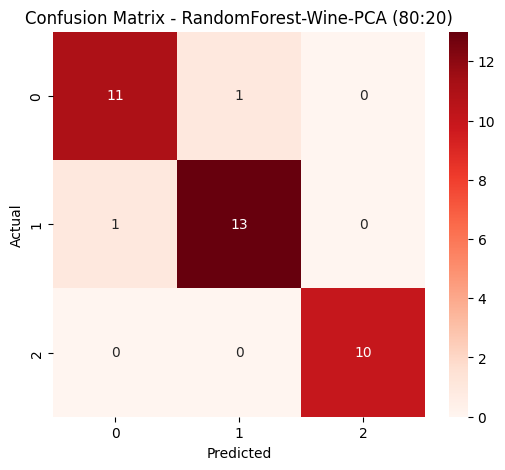

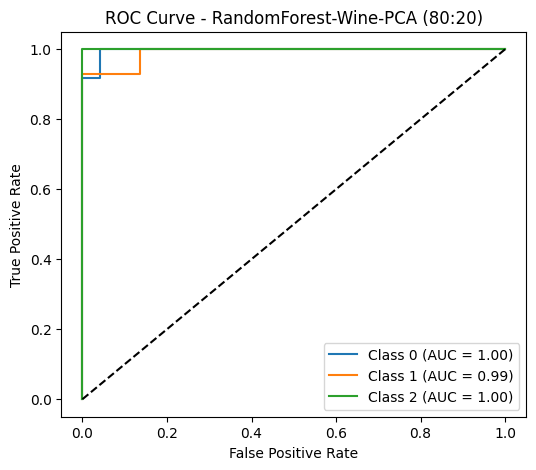

[Digits-PCA] Reduced dimensionality: 64 -> 40
SVM-linear train-test split: 50:50
[Default] SVM-linear accuracy: 0.9533
[Tuned] SVM-linear accuracy: 0.9566
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
                   Model  Split  Accuracy  Precision    Recall  F1-score
0  SVM-linear-Digits-PCA  50:50  0.956618   0.957695  0.956618  0.956419


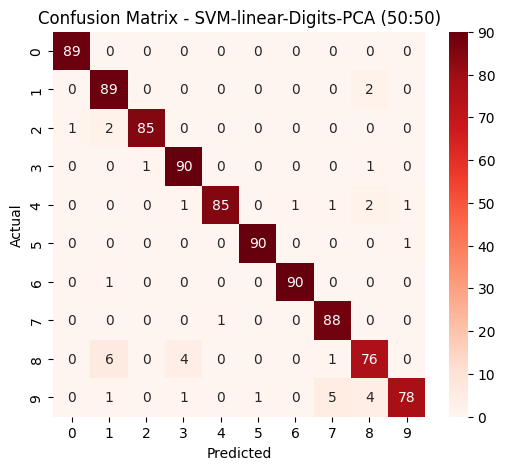

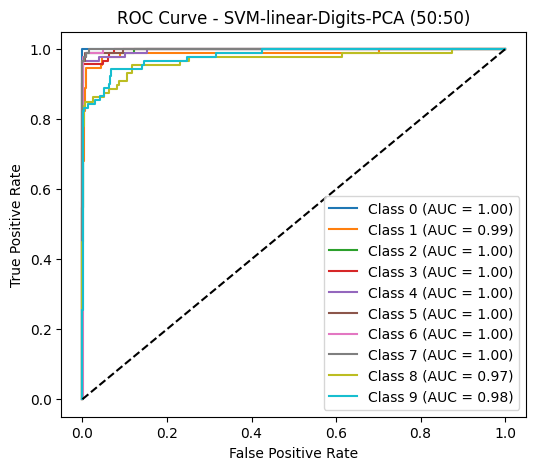

SVM-poly train-test split: 50:50
[Default] SVM-poly accuracy: 0.9689
[Tuned] SVM-poly accuracy: 0.9600
[Tuned] SVM-poly best params: {'C': 10, 'degree': 2, 'gamma': 'scale'}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
1  SVM-poly-Digits-PCA  50:50  0.959956   0.960401  0.959956  0.959862


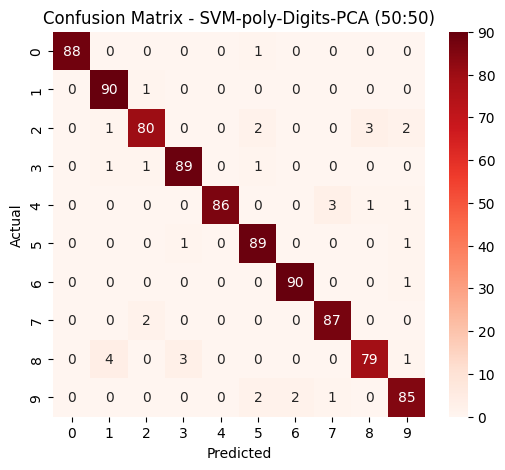

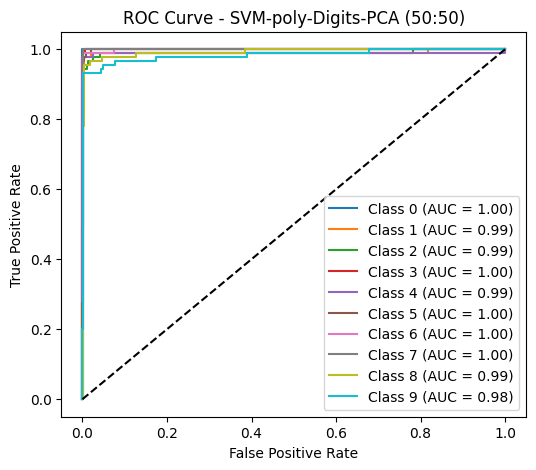

SVM-rbf train-test split: 50:50
[Default] SVM-rbf accuracy: 0.9722
[Tuned] SVM-rbf accuracy: 0.9778
[Tuned] SVM-rbf best params: {'C': 10, 'gamma': 0.01}

Evaluation Results:
                Model  Split  Accuracy  Precision    Recall  F1-score
2  SVM-rbf-Digits-PCA  50:50  0.977753   0.977889  0.977753   0.97765


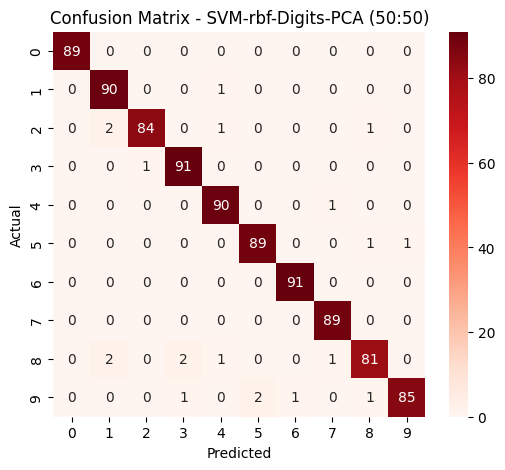

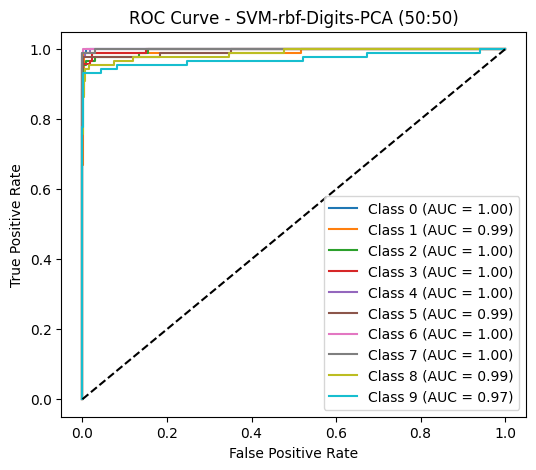

SVM-sigmoid train-test split: 50:50
[Default] SVM-sigmoid accuracy: 0.9321
[Tuned] SVM-sigmoid accuracy: 0.9321
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
                    Model  Split  Accuracy  Precision    Recall  F1-score
3  SVM-sigmoid-Digits-PCA  50:50  0.932147   0.933721  0.932147  0.932161


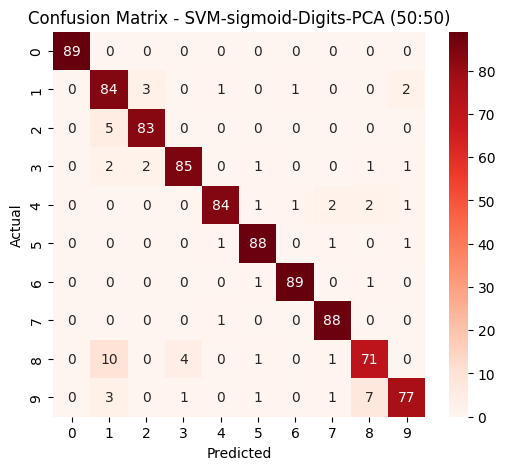

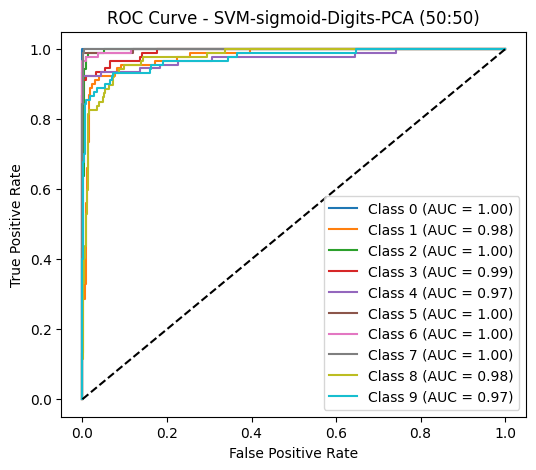

MLP train-test split: 50:50
[Default] MLP accuracy: 0.9644
[Tuned] MLP accuracy: 0.9644
[Tuned] MLP best params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 300, 'momentum': 0.8, 'solver': 'adam'}

Evaluation Results:
            Model  Split  Accuracy  Precision    Recall  F1-score
4  MLP-Digits-PCA  50:50  0.964405    0.96463  0.964405  0.964355


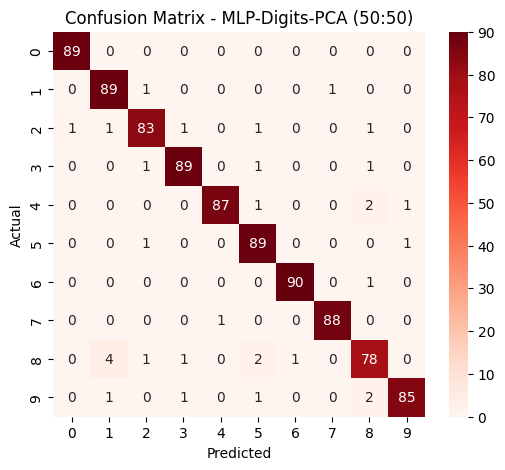

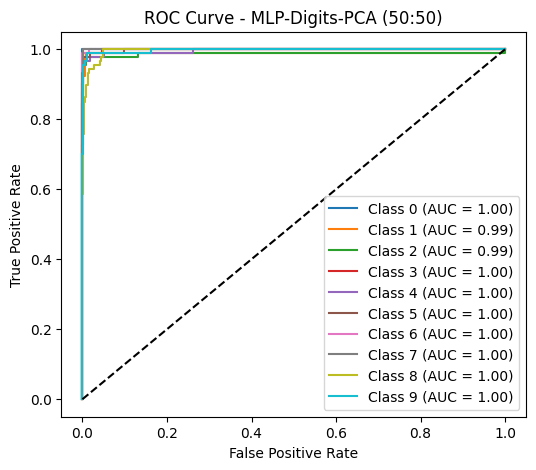

RandomForest train-test split: 50:50
[Default] RandomForest accuracy: 0.9466
[Tuned] RandomForest accuracy: 0.9344
[Tuned] RandomForest best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Evaluation Results:
                     Model  Split  Accuracy  Precision    Recall  F1-score
5  RandomForest-Digits-PCA  50:50  0.934372   0.935018  0.934372  0.933983


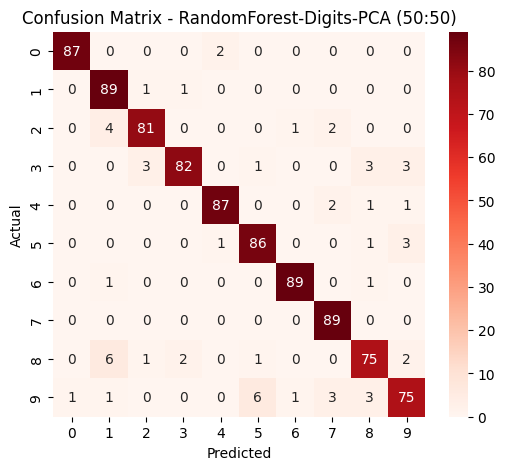

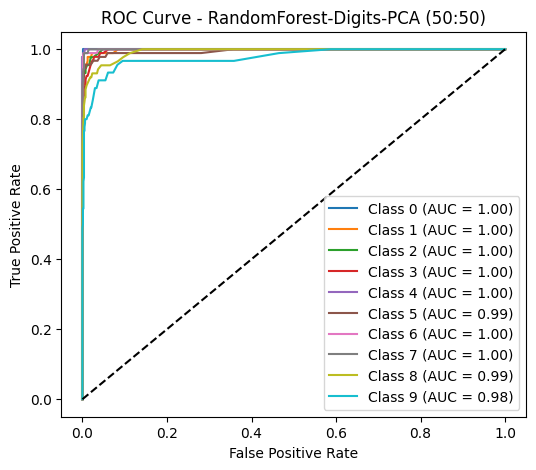

SVM-linear train-test split: 60:40
[Default] SVM-linear accuracy: 0.9499
[Tuned] SVM-linear accuracy: 0.9694
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
                   Model  Split  Accuracy  Precision    Recall  F1-score
6  SVM-linear-Digits-PCA  60:40  0.969402   0.969667  0.969402  0.969176


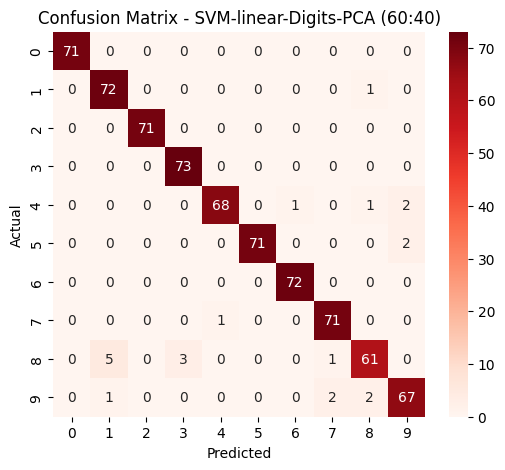

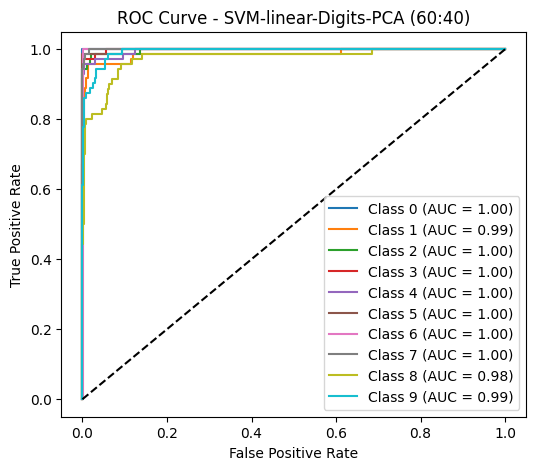

SVM-poly train-test split: 60:40
[Default] SVM-poly accuracy: 0.9736
[Tuned] SVM-poly accuracy: 0.9722
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
7  SVM-poly-Digits-PCA  60:40  0.972184   0.972922  0.972184   0.97208


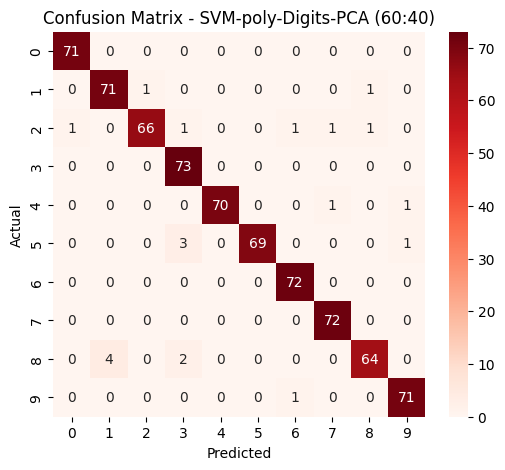

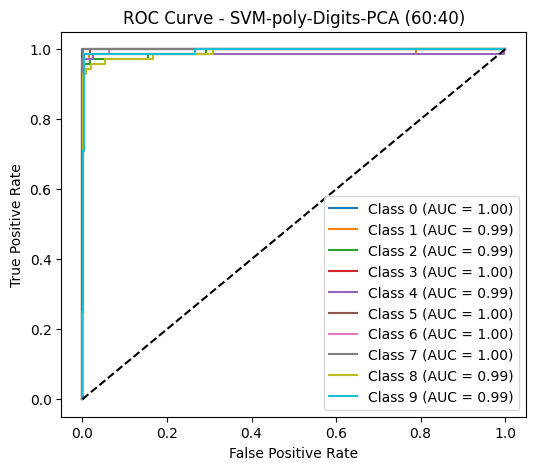

SVM-rbf train-test split: 60:40
[Default] SVM-rbf accuracy: 0.9777
[Tuned] SVM-rbf accuracy: 0.9819
[Tuned] SVM-rbf best params: {'C': 10, 'gamma': 0.01}

Evaluation Results:
                Model  Split  Accuracy  Precision    Recall  F1-score
8  SVM-rbf-Digits-PCA  60:40  0.981919   0.982185  0.981919  0.981818


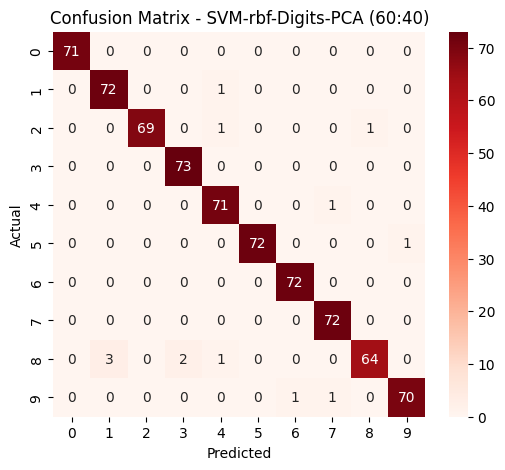

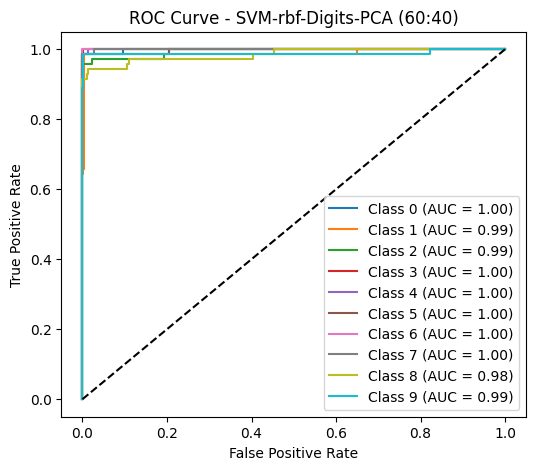

SVM-sigmoid train-test split: 60:40
[Default] SVM-sigmoid accuracy: 0.9318
[Tuned] SVM-sigmoid accuracy: 0.9318
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
                    Model  Split  Accuracy  Precision   Recall  F1-score
9  SVM-sigmoid-Digits-PCA  60:40   0.93185   0.932555  0.93185   0.93164


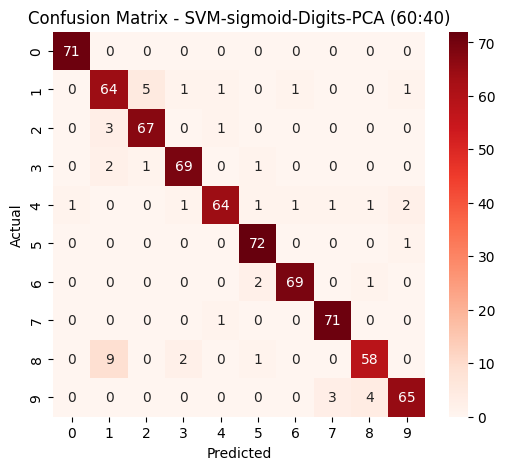

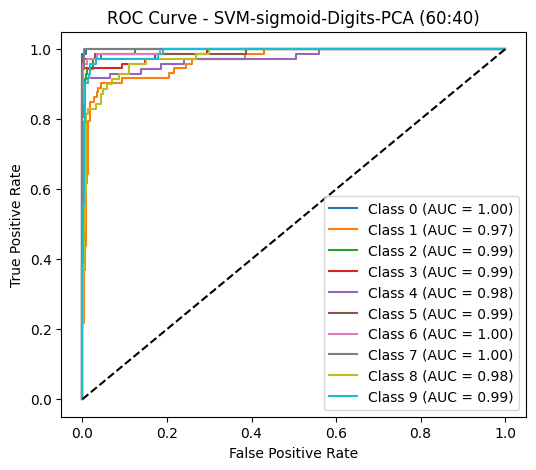

MLP train-test split: 60:40
[Default] MLP accuracy: 0.9722
[Tuned] MLP accuracy: 0.9722
[Tuned] MLP best params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 300, 'momentum': 0.8, 'solver': 'adam'}

Evaluation Results:
             Model  Split  Accuracy  Precision    Recall  F1-score
10  MLP-Digits-PCA  60:40  0.972184   0.972989  0.972184  0.972157


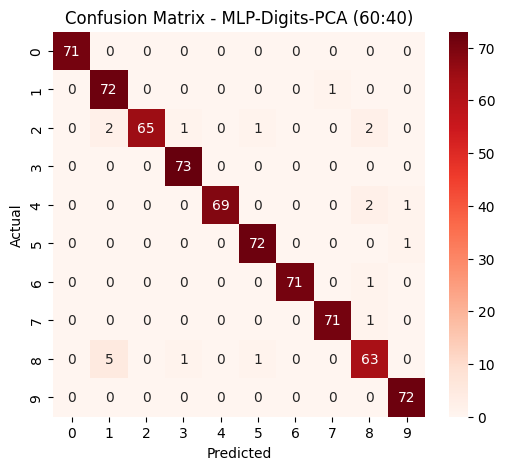

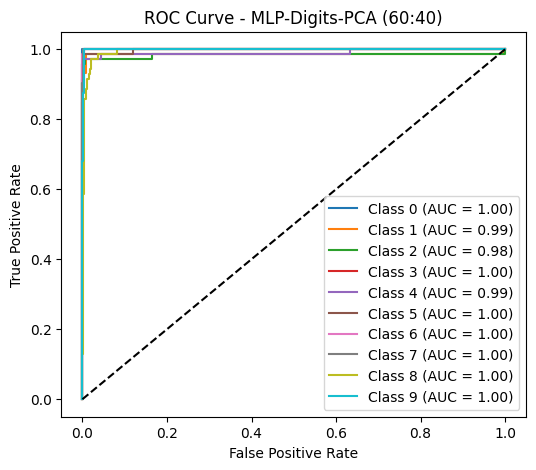

RandomForest train-test split: 60:40
[Default] RandomForest accuracy: 0.9471
[Tuned] RandomForest accuracy: 0.9485
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Evaluation Results:
                      Model  Split  Accuracy  Precision   Recall  F1-score
11  RandomForest-Digits-PCA  60:40   0.94854   0.949175  0.94854  0.948414


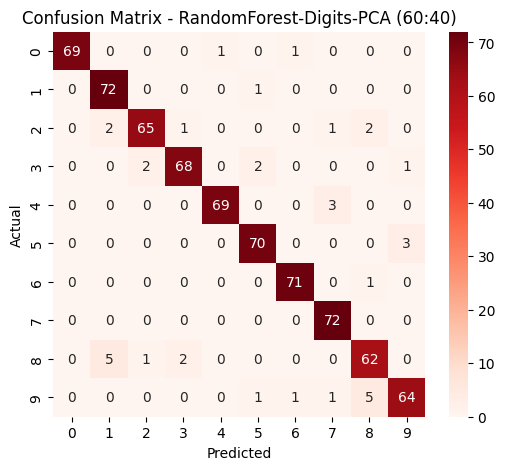

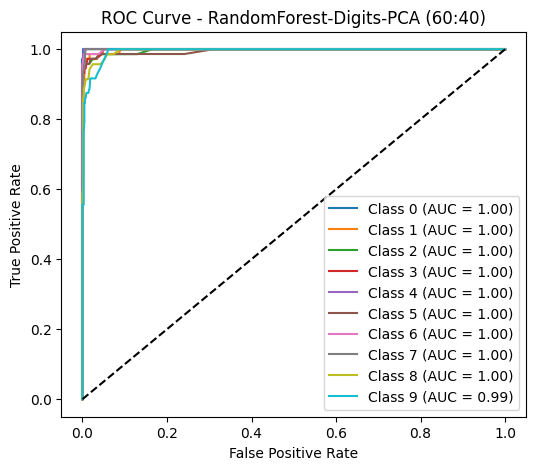

SVM-linear train-test split: 70:30
[Default] SVM-linear accuracy: 0.9556
[Tuned] SVM-linear accuracy: 0.9704
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
                    Model  Split  Accuracy  Precision   Recall  F1-score
12  SVM-linear-Digits-PCA  70:30   0.97037   0.970344  0.97037  0.970145


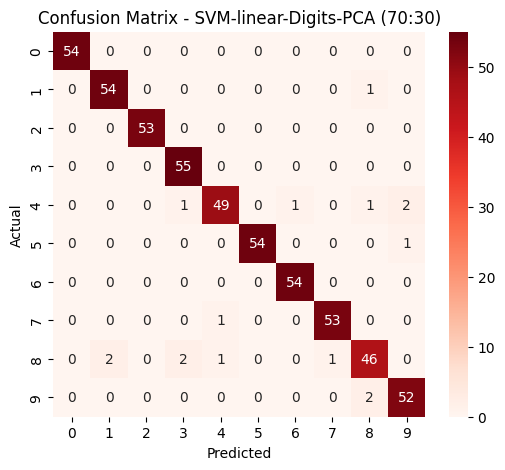

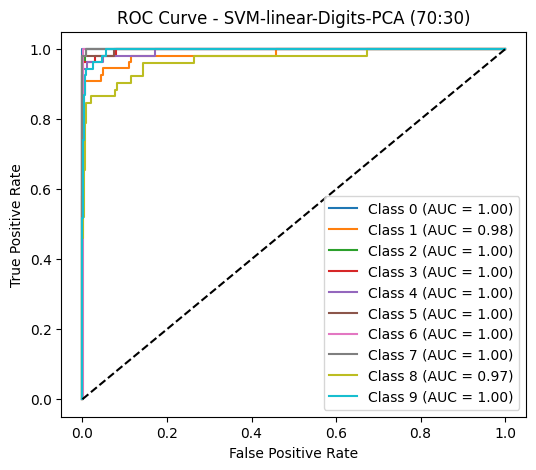

SVM-poly train-test split: 70:30
[Default] SVM-poly accuracy: 0.9778
[Tuned] SVM-poly accuracy: 0.9759
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
13  SVM-poly-Digits-PCA  70:30  0.975926   0.976384  0.975926  0.975816


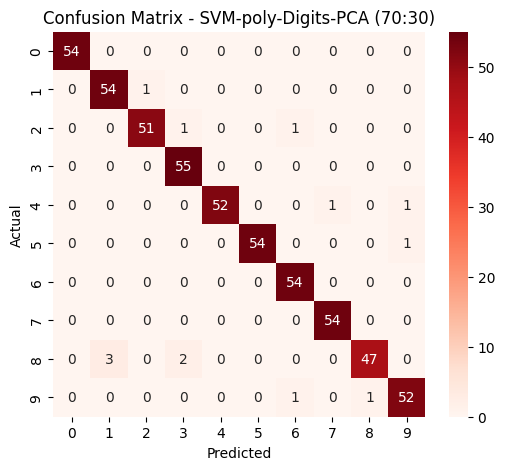

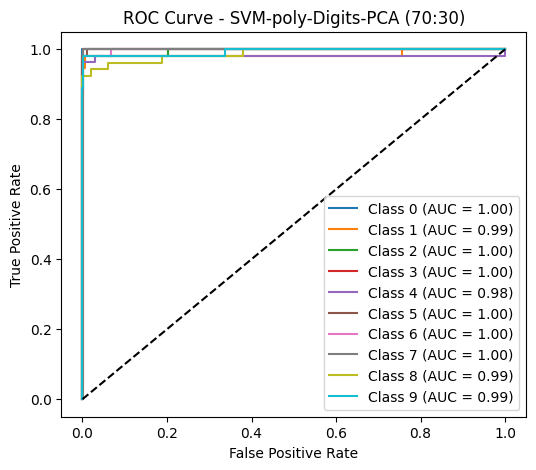

SVM-rbf train-test split: 70:30
[Default] SVM-rbf accuracy: 0.9741
[Tuned] SVM-rbf accuracy: 0.9759
[Tuned] SVM-rbf best params: {'C': 10, 'gamma': 'auto'}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
14  SVM-rbf-Digits-PCA  70:30  0.975926   0.976295  0.975926  0.975836


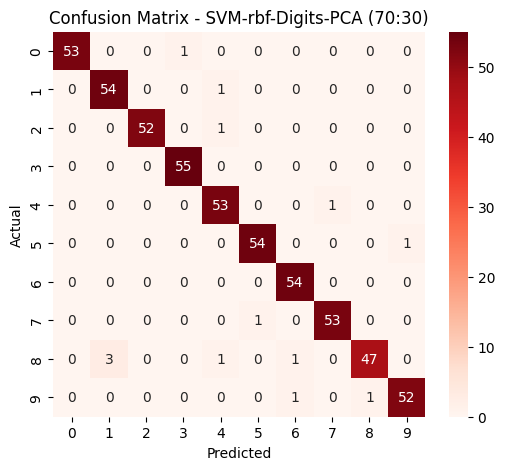

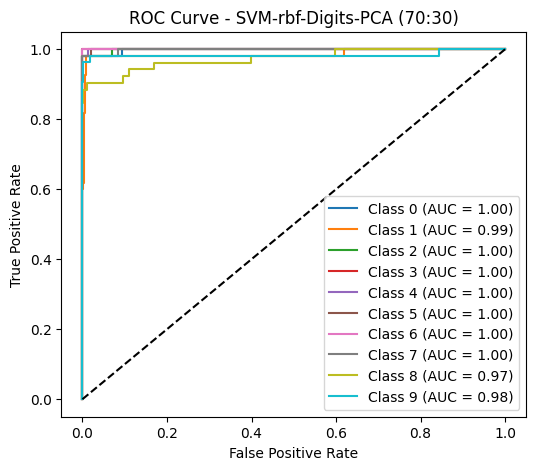

SVM-sigmoid train-test split: 70:30
[Default] SVM-sigmoid accuracy: 0.9296
[Tuned] SVM-sigmoid accuracy: 0.9296
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'auto'}

Evaluation Results:
                     Model  Split  Accuracy  Precision   Recall  F1-score
15  SVM-sigmoid-Digits-PCA  70:30   0.92963    0.93537  0.92963  0.930546


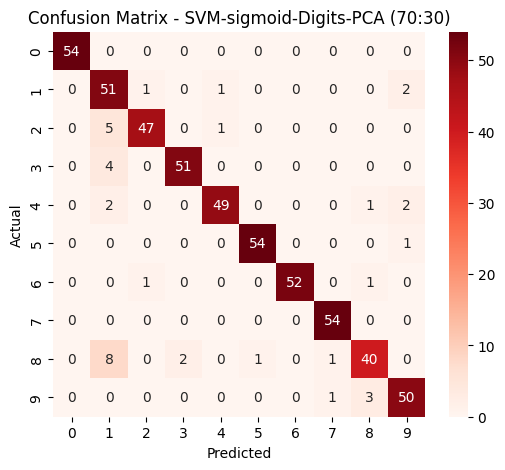

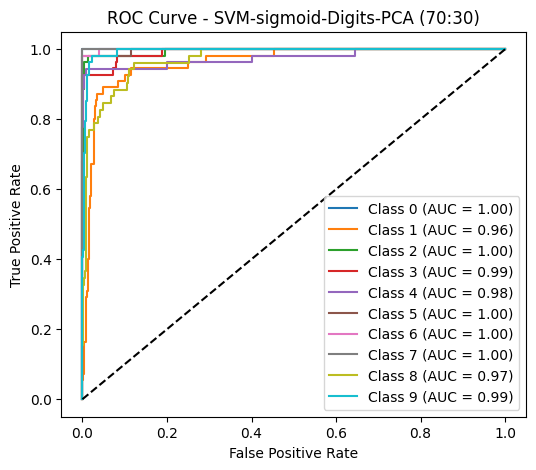

MLP train-test split: 70:30
[Default] MLP accuracy: 0.9722
[Tuned] MLP accuracy: 0.9722
[Tuned] MLP best params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 300, 'momentum': 0.8, 'solver': 'adam'}

Evaluation Results:
             Model  Split  Accuracy  Precision    Recall  F1-score
16  MLP-Digits-PCA  70:30  0.972222   0.972754  0.972222  0.972179


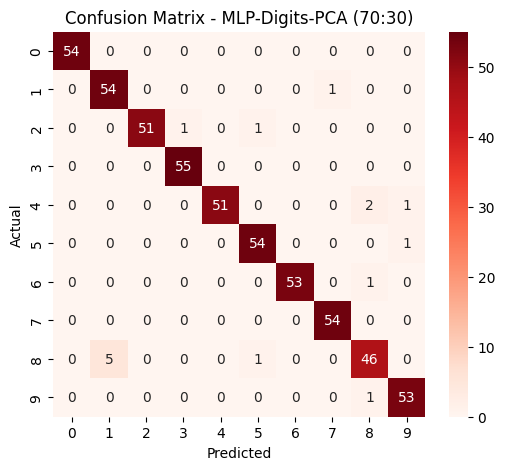

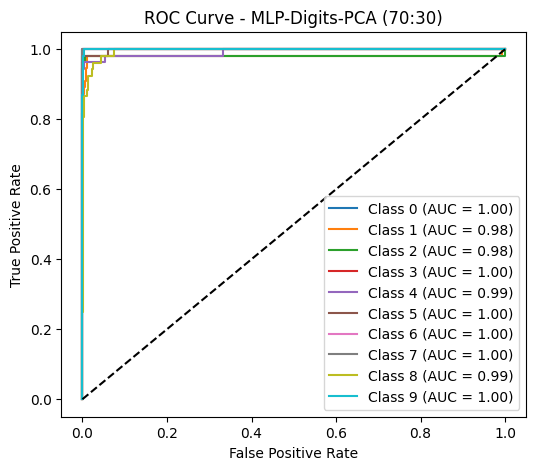

RandomForest train-test split: 70:30
[Default] RandomForest accuracy: 0.9537
[Tuned] RandomForest accuracy: 0.9537
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Evaluation Results:
                      Model  Split  Accuracy  Precision    Recall  F1-score
17  RandomForest-Digits-PCA  70:30  0.953704   0.954726  0.953704  0.953727


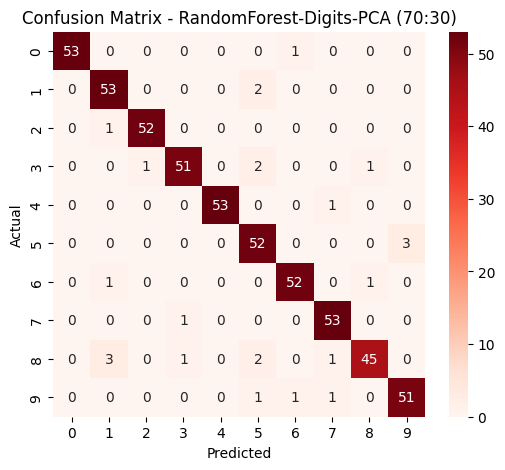

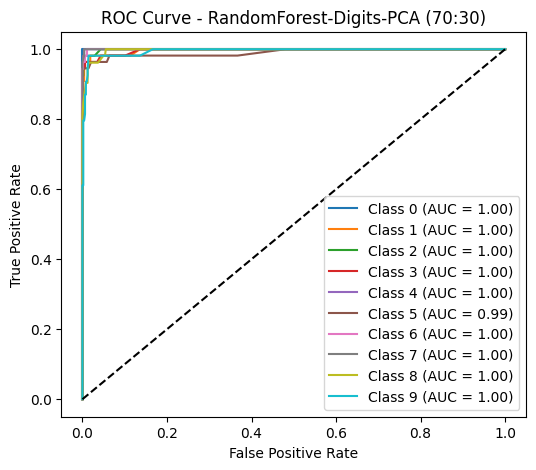

SVM-linear train-test split: 80:20
[Default] SVM-linear accuracy: 0.9583
[Tuned] SVM-linear accuracy: 0.9778
[Tuned] SVM-linear best params: {'C': 0.1}

Evaluation Results:
                    Model  Split  Accuracy  Precision    Recall  F1-score
18  SVM-linear-Digits-PCA  80:20  0.977778   0.977872  0.977778  0.977425


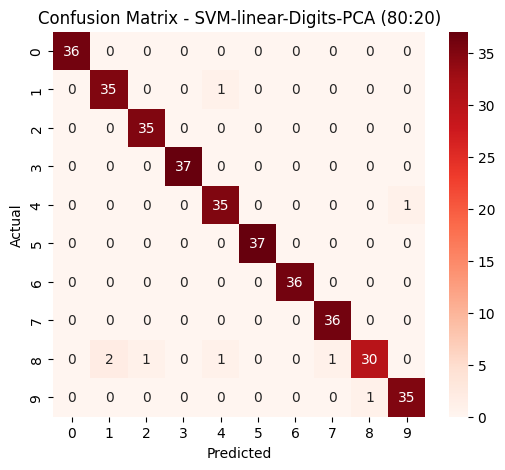

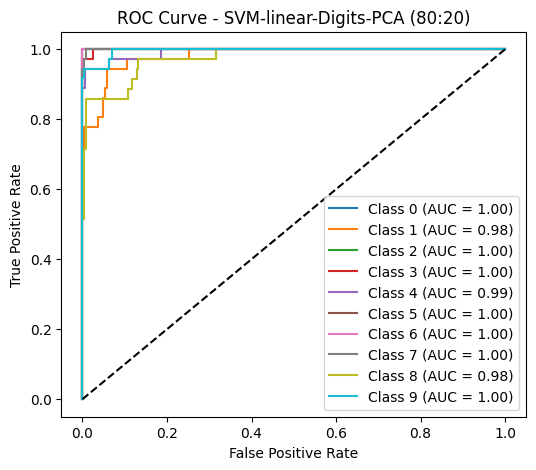

SVM-poly train-test split: 80:20
[Default] SVM-poly accuracy: 0.9833
[Tuned] SVM-poly accuracy: 0.9806
[Tuned] SVM-poly best params: {'C': 10, 'degree': 3, 'gamma': 'scale'}

Evaluation Results:
                  Model  Split  Accuracy  Precision    Recall  F1-score
19  SVM-poly-Digits-PCA  80:20  0.980556   0.980683  0.980556  0.980428


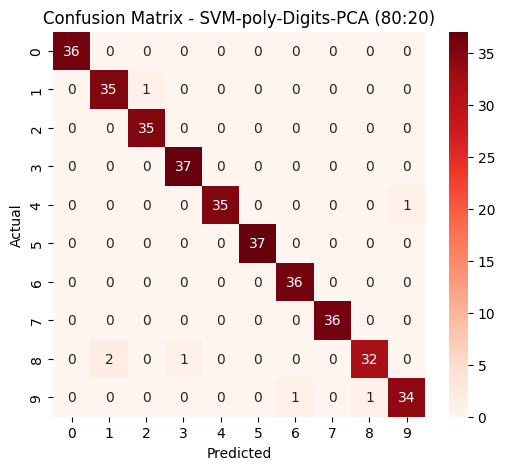

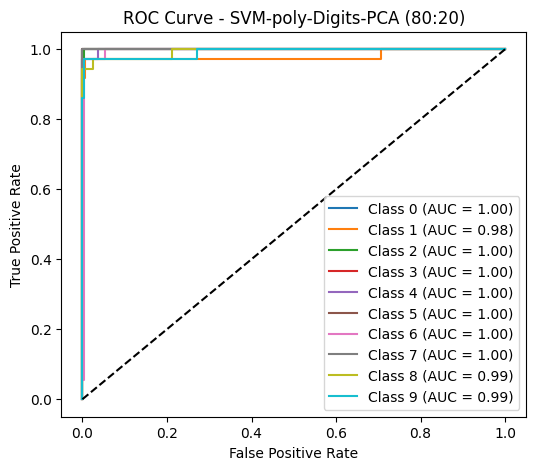

SVM-rbf train-test split: 80:20
[Default] SVM-rbf accuracy: 0.9750
[Tuned] SVM-rbf accuracy: 0.9778
[Tuned] SVM-rbf best params: {'C': 10, 'gamma': 'scale'}

Evaluation Results:
                 Model  Split  Accuracy  Precision    Recall  F1-score
20  SVM-rbf-Digits-PCA  80:20  0.977778   0.978068  0.977778  0.977732


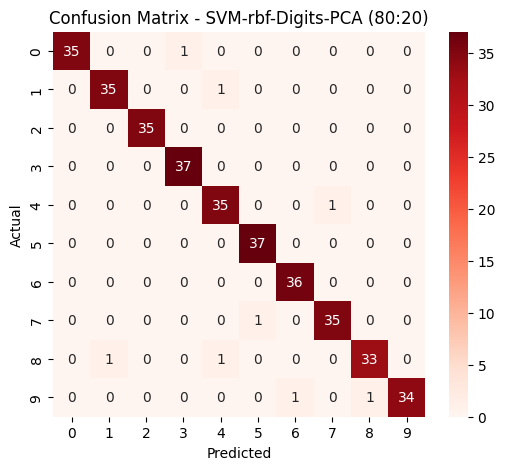

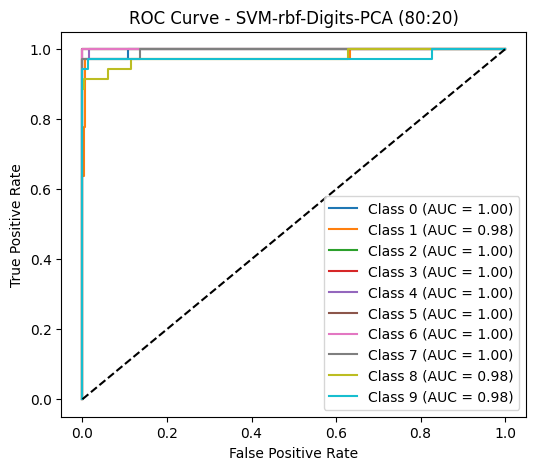

SVM-sigmoid train-test split: 80:20
[Default] SVM-sigmoid accuracy: 0.9306
[Tuned] SVM-sigmoid accuracy: 0.9306
[Tuned] SVM-sigmoid best params: {'C': 1, 'gamma': 'scale'}

Evaluation Results:
                     Model  Split  Accuracy  Precision    Recall  F1-score
21  SVM-sigmoid-Digits-PCA  80:20  0.930556   0.934955  0.930556  0.931299


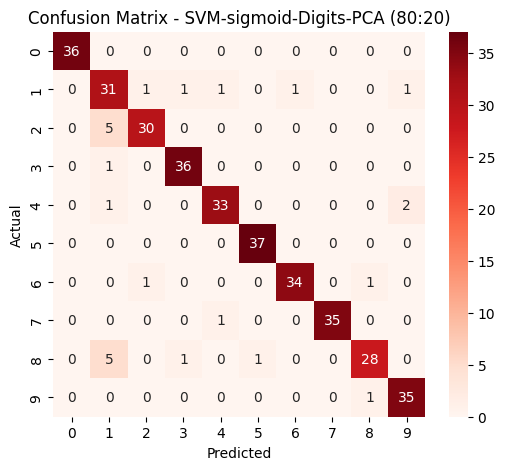

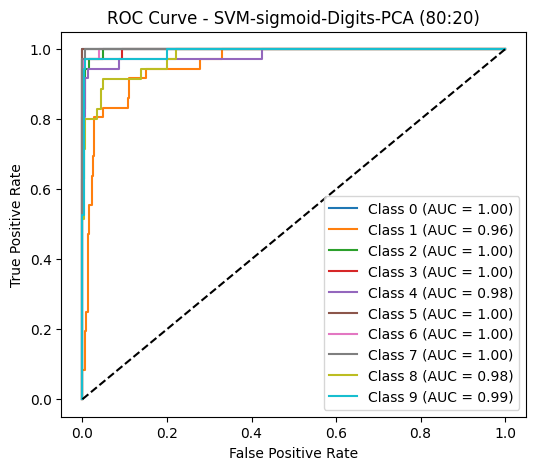

MLP train-test split: 80:20
[Default] MLP accuracy: 0.9833
[Tuned] MLP accuracy: 0.9750
[Tuned] MLP best params: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 300, 'momentum': 0.9, 'solver': 'sgd'}

Evaluation Results:
             Model  Split  Accuracy  Precision  Recall  F1-score
22  MLP-Digits-PCA  80:20     0.975   0.975261   0.975   0.97478


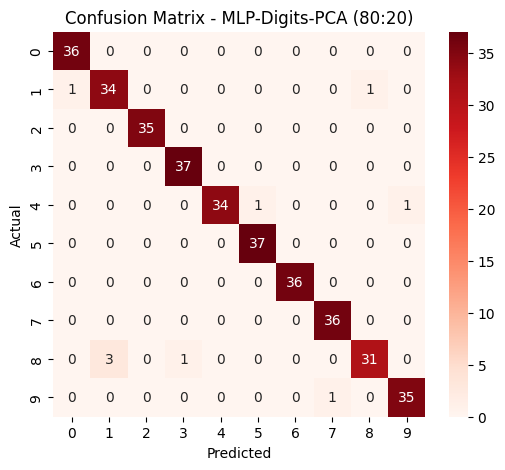

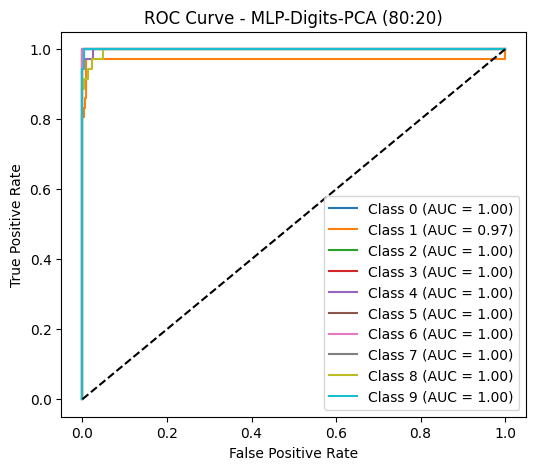

RandomForest train-test split: 80:20
[Default] RandomForest accuracy: 0.9556
[Tuned] RandomForest accuracy: 0.9556
[Tuned] RandomForest best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Evaluation Results:
                      Model  Split  Accuracy  Precision    Recall  F1-score
23  RandomForest-Digits-PCA  80:20  0.955556   0.955857  0.955556  0.955103


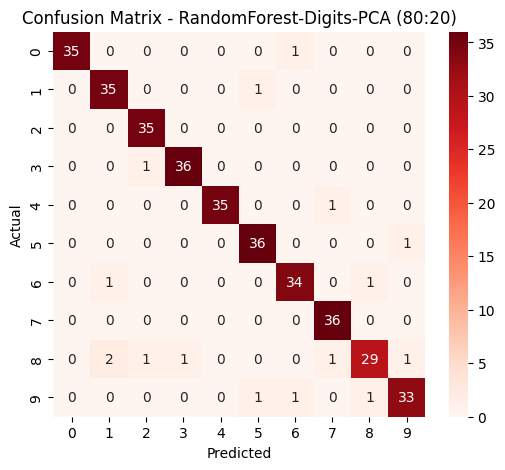

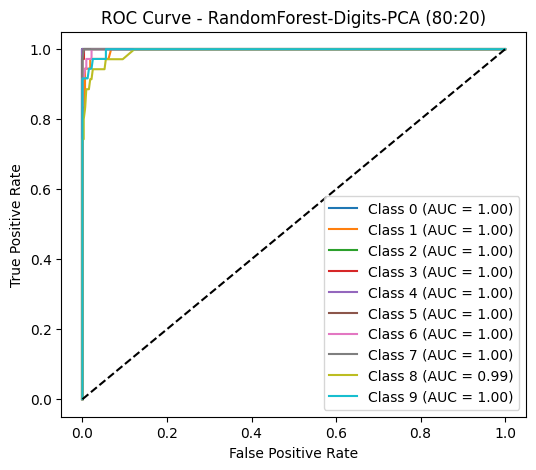

In [57]:
results_wine_pca = train_and_evaluate_with_pca(wine.data, wine.target, "Wine")
results_digits_pca = train_and_evaluate_with_pca(digits.data, digits.target, "Digits")

# Results

In [58]:
all_results = pd.concat([results_wine, results_digits, results_wine_pca, results_digits_pca], ignore_index=True)

print("Results Summary:")
display(all_results)

all_results.to_csv(os.path.join(folder_path, 'classification_results.csv'), index=False)

Results Summary:


Model  Split  Accuracy  Precision    Recall  F1-score
0           SVM-linear-Wine  50:50  0.977528   0.978340  0.977528  0.977404
1             SVM-poly-Wine  50:50  0.921348   0.924041  0.921348  0.920633
2              SVM-rbf-Wine  50:50  0.977528   0.977528  0.977528  0.977528
3          SVM-sigmoid-Wine  50:50  0.966292   0.966411  0.966292  0.966163
4                  MLP-Wine  50:50  0.977528   0.979257  0.977528  0.977647
..                      ...    ...       ...        ...       ...       ...
91      SVM-poly-Digits-PCA  80:20  0.980556   0.980683  0.980556  0.980428
92       SVM-rbf-Digits-PCA  80:20  0.977778   0.978068  0.977778  0.977732
93   SVM-sigmoid-Digits-PCA  80:20  0.930556   0.934955  0.930556  0.931299
94           MLP-Digits-PCA  80:20  0.975000   0.975261  0.975000  0.974780
95  RandomForest-Digits-PCA  80:20  0.955556   0.955857  0.955556  0.955103

[96 rows x 6 columns]